# P3 - Open Food Facts - Nettoyage et Exploration

### Import

In [1]:
import sys
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set()

%matplotlib inline

### Error Management

In [2]:
logging.basicConfig(level=logging.INFO)

In [3]:
# Les separateurs ne sont pas des comma habituelles, ici il sagit de tabulation. low_memory=False est precise
data = pd.read_csv('../Source/fr.openfoodfacts.org.products.csv', sep='\t', low_memory=False, encoding='UTF-8')

In [4]:
print(data.shape)
print(data.dtypes.value_counts())
print(data.isnull().sum().sort_values(ascending=False))

(320772, 162)
float64    106
object      56
Name: count, dtype: int64
water-hardness_100g                      320772
no_nutriments                            320772
ingredients_that_may_be_from_palm_oil    320772
nutrition_grade_uk                       320772
nervonic-acid_100g                       320772
                                          ...  
created_datetime                              9
created_t                                     3
creator                                       2
last_modified_datetime                        0
last_modified_t                               0
Length: 162, dtype: int64


In [5]:
def filling_rate(dataframe):
    
    # get the numbers of rows and columns in the dataframe
    nb_rows, nb_columns = dataframe.shape
    # print("DataFrame has {} rows and {} columns.".format(nb_rows,nb_columns))

    # get the number of non-Nan data in the dataframe
    nb_data = dataframe.count().sum()

    # computing the filling rate
    filling_rate = nb_data / (nb_rows * nb_columns)
    print("The global filling rate of the DataFrame is : {:.2%}".format(filling_rate))
      
    # Setting frequencies and labels for pie plot
    frequencies = [filling_rate, 1 - filling_rate]
    labels = ["Filled data", "Missing data"]
    
    # General informations for the pie plot
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title("Filling of the DataFrame", fontsize=25)
    ax.axis("equal")
    explode = (0.1, 0)  # only "explode" the 1st slice

    # Plotting pie plot
    ax.pie(frequencies,
           explode=explode,
           # labels=labels,
           autopct='%1.2f%%',
           shadow=True,
          )
    plt.legend(labels)

The global filling rate of the DataFrame is : 23.78%


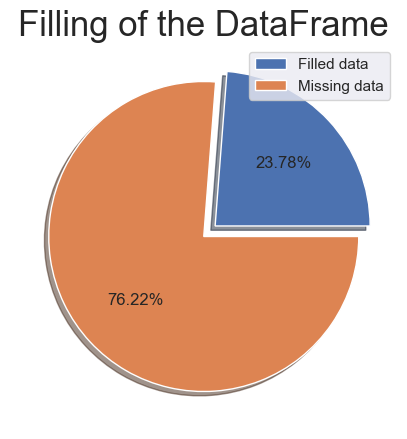

In [6]:
filling_rate(data)

### Beaucoup de valeurs manquantes sont presentes dans ce jeu de donnees. Il faudra alors appliquer plusieurs methodes dans le but de limiter/combler ces valeurs absentes.
### Dans un premier temps nous pouvons dire que toutes les variables vide ou quasiment vide peuvent etre retirees completement. 
### Les variables dont le taux de valeurs manquantes sera superieur ou egale a 70% seront donc retirees.
### Ensuite, il faudra proceder autrement.
### Imputation par : 0 si la valeurs de la variable ne peut pas etre trouvee. Par la moyenne si la variance de la variable est plutot faible. Par la medianne si la variance de la variable est elevee (plus robuste que la moyenne si variance elevee). 
### Enfin une autre methode d'imputation peut etre utilisee comme le SimpleImputer ou les KNN. Celle ci devra repondre a certaines conditions afin de ne pas creer de fausses relations (correlations) entre les varaibles.

### Description du jeu de donnee

In [7]:
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Chaque colonne correspond à une variable (feature), et chaque ligne correspond à un produit.

In [8]:
data_shape = data.shape
print(f"Le jeu de donnee contient {data_shape[0]} lignes et {data_shape[1]} colonnes.")

Le jeu de donnee contient 320772 lignes et 162 colonnes.


In [9]:
data.describe(include='all')

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,320749,320749,320770,320769,320763,320772,320772,303010,52795,104819,...,49.000000,3036.000000,165.000000,948.000000,0.0,268.000000,221210.000000,221210.000000,0.0,0.0
unique,320749,320749,3535,189567,189568,180495,180495,221347,38584,13826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489077120,2017-03-09T10:37:09Z,1439141742,2015-08-09T17:35:42Z,Ice Cream,Pâtes alimentaires au blé dur de qualité supér...,500 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,169868,20,20,33,33,410,201,4669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.425698,31.458587,15.412121,49.547785,NaN,341.700764,9.165535,9.058049,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.047841,31.967918,3.753028,18.757932,NaN,425.211439,9.055903,9.183589,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,8.000000,6.000000,NaN,0.000000,-15.000000,-15.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.300000,0.000000,12.000000,32.000000,NaN,98.750000,1.000000,1.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.200000,23.000000,15.000000,50.000000,NaN,195.750000,10.000000,9.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.400000,51.000000,15.000000,64.250000,NaN,383.200000,16.000000,16.000000,NaN,NaN


### Description variable categorielle

In [10]:
data_lignes = data_shape[0]
desc_var = data.describe(exclude=[np.number])

desc_type = pd.DataFrame(desc_var.dtypes, columns=['type']).T
nb_nan = data_lignes - desc_var.loc['count'].T
pourcentage_nan = nb_nan * 100 / data_lignes
desc_nan = pd.DataFrame([nb_nan, pourcentage_nan], index=['nb_nan', '%_nan'])
desc_var = pd.concat([desc_type, desc_nan, desc_var])

In [11]:
desc_var

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url
type,object,object,object,object,object,object,object,object,object,object,...,object,object,object,object,object,object,object,object,object,object
nb_nan,23.0,23.0,2.0,3.0,9.0,0.0,0.0,17762.0,267977.0,215953.0,...,99562.0,229259.0,226281.0,46.0,46.0,46.0,236406.0,236406.0,244936.0,244936.0
%_nan,0.00717,0.00717,0.000623,0.000935,0.002806,0.0,0.0,5.537266,83.541269,67.322896,...,31.038245,71.471014,70.542628,0.01434,0.01434,0.01434,73.699076,73.699076,76.358286,76.358286
count,320749,320749,320770,320769,320763,320772,320772,303010,52795,104819,...,221210,91513,94491,320726,320726,320726,84366,84366,75836,75836
unique,320749,320749,3535,189567,189568,180495,180495,221347,38584,13826,...,5,14,42,1021,1021,1021,3543,3543,75836,75836
top,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489077120,2017-03-09T10:37:09Z,1439141742,2015-08-09T17:35:42Z,Ice Cream,Pâtes alimentaires au blé dur de qualité supér...,500 g,...,d,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",en:beverages,Boissons,http://fr.openfoodfacts.org/images/products/00...,http://fr.openfoodfacts.org/images/products/00...
freq,1,1,169868,20,20,33,33,410,201,4669,...,62763,22624,22624,168905,168905,168905,6054,6054,1,1


#### 23 unites de difference entre le nombre de ligne (320772) et le nombre de code (320449)

### Description variable quantitatve

In [12]:
data_lignes = data_shape[0]
desc_var = data.describe()

desc_type = pd.DataFrame(desc_var.dtypes, columns=['type']).T
nb_nan = data_lignes - desc_var.loc['count'].T
pourcentage_nan = nb_nan * 100 / data_lignes
desc_nan = pd.DataFrame([nb_nan, pourcentage_nan], index=['nb_nan', '%_nan'])
desc_var = pd.concat([desc_type, desc_nan, desc_var])

In [13]:
desc_var

,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
nb_nan,320772.0,71833.0,71833.0,320772.0,71833.0,320772.0,320772.0,59659.0,319915.0,76881.0,...,320723.0,317736.0,320607.0,319824.0,320772.0,320504.0,99562.0,99562.0,320772.0,320772.0
%_nan,100.0,22.393787,22.393787,100.0,22.393787,100.0,100.0,18.598568,99.732832,23.967491,...,99.984724,99.053533,99.948562,99.704463,100.0,99.916452,31.038245,31.038245,100.0,100.0
count,0.0,248939.0,248939.0,0.0,248939.0,0.0,0.0,261113.0,857.0,243891.0,...,49.0,3036.0,165.0,948.0,0.0,268.0,221210.0,221210.0,0.0,0.0
mean,NaN,1.936024,0.019659,NaN,0.055246,NaN,NaN,1141.914605,585.501214,12.730379,...,6.425698,31.458587,15.412121,49.547785,NaN,341.700764,9.165535,9.058049,NaN,NaN
std,NaN,2.502019,0.140524,NaN,0.269207,NaN,NaN,6447.154093,712.809943,17.578747,...,2.047841,31.967918,3.753028,18.757932,NaN,425.211439,9.055903,9.183589,NaN,NaN
min,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,8.0,6.0,NaN,0.0,-15.0,-15.0,NaN,NaN
25%,NaN,0.0,0.0,NaN,0.0,NaN,NaN,377.0,49.4,0.0,...,6.3,0.0,12.0,32.0,NaN,98.75,1.0,1.0,NaN,NaN
50%,NaN,1.0,0.0,NaN,0.0,NaN,NaN,1100.0,300.0,5.0,...,7.2,23.0,15.0,50.0,NaN,195.75,10.0,9.0,NaN,NaN
75%,NaN,3.0,0.0,NaN,0.0,NaN,NaN,1674.0,898.0,20.0,...,7.4,51.0,15.0,64.25,NaN,383.2,16.0,16.0,NaN,NaN


#### On remarque que dans plusieurs colonnes _100g, des valeurs supperieurs a 100 sont presentes

In [14]:
data.head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
print(list(data))

['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'nutrition_grade_fr', 'pnns_groups_1', 

In [16]:
data.dtypes

code                        object
url                         object
creator                     object
created_t                   object
created_datetime            object
                            ...   
carbon-footprint_100g      float64
nutrition-score-fr_100g    float64
nutrition-score-uk_100g    float64
glycemic-index_100g        float64
water-hardness_100g        float64
Length: 162, dtype: object

## Transtypage des donnees

#### Variable temporelle

In [17]:
# List of date and time features
datetime_features = [
    'created_datetime',
    'last_modified_datetime',
    'created_t',
    'last_modified_t',
]

In [18]:
for feature in datetime_features:
    try:
        data[feature] = pd.to_datetime(data[feature], errors='raise', utc=True)
        print(f"✅ {feature} converti sans erreur.")
    except Exception as e:
        print(f"❌ Erreur sur {feature} : {e}")

❌ Erreur sur created_datetime : time data "Dia,Sogeres" doesn't match format "%Y-%m-%dT%H:%M:%S%z", at position 63978. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.
❌ Erreur sur last_modified_datetime : time data "en:belgium,en:france" doesn't match format "%Y-%m-%dT%H:%M:%S%z", at position 62064. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.
❌ Erreur sur created_t : year 1474103866 is out of range:

C:\Users\cosic\AppData\Local\Temp\ipykernel_25580\2033113051.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[feature] = pd.to_datetime(data[feature], errors='raise', utc=True)
C:\Users\cosic\AppData\Local\Temp\ipykernel_25580\2033113051.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[feature] = pd.to_datetime(data[feature], errors='raise', utc=True)


In [19]:
# Convertir les timestamps Unix en datetime (unit='s' pour secondes)
data["created_t"] = pd.to_datetime(data["created_t"], unit="s", errors="coerce", utc=True)
data["last_modified_t"] = pd.to_datetime(data["last_modified_t"], unit="s", errors="coerce", utc=True)

In [20]:
data[datetime_features].dtypes

created_datetime                       object
last_modified_datetime                 object
created_t                 datetime64[ns, UTC]
last_modified_t           datetime64[ns, UTC]
dtype: object

#### Variables catégorielles nominales

In [21]:
# List of nominal features
nominal_features = [
    'categories',
    'categories_tags',
    'categories_fr',
]

# Converting the dtype for nominal features
for feature in nominal_features:
    data[feature] = data[feature].astype('category')

#### Variables catégorielles ordinales

In [22]:
# List of ordinal features
ordinal_features = [
    'nutrition_grade_fr',
]

# Converting the dtype of ordinal features
from pandas.api.types import CategoricalDtype

for feature in ordinal_features:
    data[feature] = data[feature].astype(CategoricalDtype(ordered=True))

In [23]:
def piechart_dtypes(dataframe):
    """Plot a piechart of dtypes of features in the dataframe"""
    
    # Loading libraries
    import matplotlib.pyplot as plt
    
    # get the list of the dtypes in the dataframe
    dtypes_count = dataframe.dtypes.value_counts()

    # Set frequencies and labels
    labels = dtypes_count.index.values
    frequencies = dtypes_count.values

    # General informations for the pie plot
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.title("Types of features", fontsize=25)
    ax.axis("equal")

    # Plotting pie plot
    ax.pie(frequencies,
            # labels=labels,
            autopct='%1.2f%%',
            shadow=True,
              )
    plt.legend(labels)

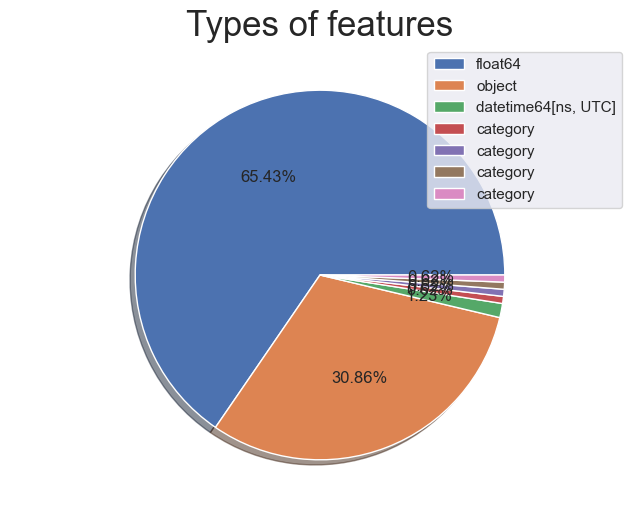

In [24]:
dataframe = data
piechart_dtypes(dataframe)

#### Certaines features ne sont pas correctement categorisees car elles n'ont pas ete renseignees dans les groupes. Mais cela nous donne quand meme un vision du dataframe.

## Elimination des colonnes non pertinentes pour l'etude.

In [25]:
# List of columns to drop
columns_useless = [
    'url',
    'creator',
    'image_url',
    'image_small_url',
    
    'created_datetime',
    'last_modified_datetime',
    'created_t',
    'last_modified_t',
    
    'states',
    'states_tags',
    'states_fr',

    'quantity',
    'packaging',
    'packaging_tags',

    'origins',
    'origins_tags',
    'manufacturing_places',
    'manufacturing_places_tags',

    'emb_codes',
    'emb_codes_tags',
    'first_packaging_code_geo',

]

# Droping useless columns
data = dataframe.drop(columns=columns_useless)

## Selection des produits vendus sur le marche Francais

In [26]:
data['countries_fr'].value_counts()

countries_fr
États-Unis                                      172998
France                                           94392
Suisse                                           14953
Allemagne                                         7870
Espagne                                           5009
                                                 ...  
Danemark,Suisse,en:Deutschland,en:Frankreich         1
France,Luxembourg,Suisse                             1
Autriche,République tchèque,Allemagne                1
Allemagne,Hongrie                                    1
Chine,Hong Kong                                      1
Name: count, Length: 722, dtype: int64

## Filtre sur la France

In [27]:
mask = data['countries_fr'].str.contains('France', na=False)
data_fr = data[mask].drop(['countries', 'countries_tags', 'countries_fr'], axis=1)

In [28]:
data_fr.shape

(98440, 138)

### On constate que nous avons reduit drastiquement la taille de notre dataframe. ~320k lignes a ~98k lignes.

## Verifions le pourcentage des valeurs manquantes

In [29]:
nan_tot =  data_fr.isna().sum().sum()
data_tot = np.product(data_fr.shape)
percentage = round((nan_tot / data_tot) * 100, 2)
print(f'Valeurs manquantes :{nan_tot} NaN pour {data_tot} données ({percentage} %)')

Valeurs manquantes :11360795 NaN pour 13584720 données (83.63 %)


#### On observe que dans le jeu de donnnees, 83% des valeurs sont manquantes.

In [30]:
values = data_fr.isnull().sum()
percentage = 100 * values / len(data_fr)
table = pd.concat([values, percentage.round(2)], axis=1)
table.columns = ['Nombres de valeurs manquantes', '% de valeurs manquantes']
table.loc[table['Nombres de valeurs manquantes'] != 0].sort_values('% de valeurs manquantes', ascending=False).style.background_gradient('Greens')

,Nombres de valeurs manquantes,% de valeurs manquantes
water-hardness_100g,98440,100.000000
ingredients_that_may_be_from_palm_oil,98440,100.000000
gamma-linolenic-acid_100g,98439,100.000000
melissic-acid_100g,98440,100.000000
montanic-acid_100g,98439,100.000000
cerotic-acid_100g,98440,100.000000
ingredients_from_palm_oil,98440,100.000000
lignoceric-acid_100g,98440,100.000000
behenic-acid_100g,98440,100.000000
arachidic-acid_100g,98439,100.000000


#### De nombreuses valeurs depassent les 70% de valeurs manquantes

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


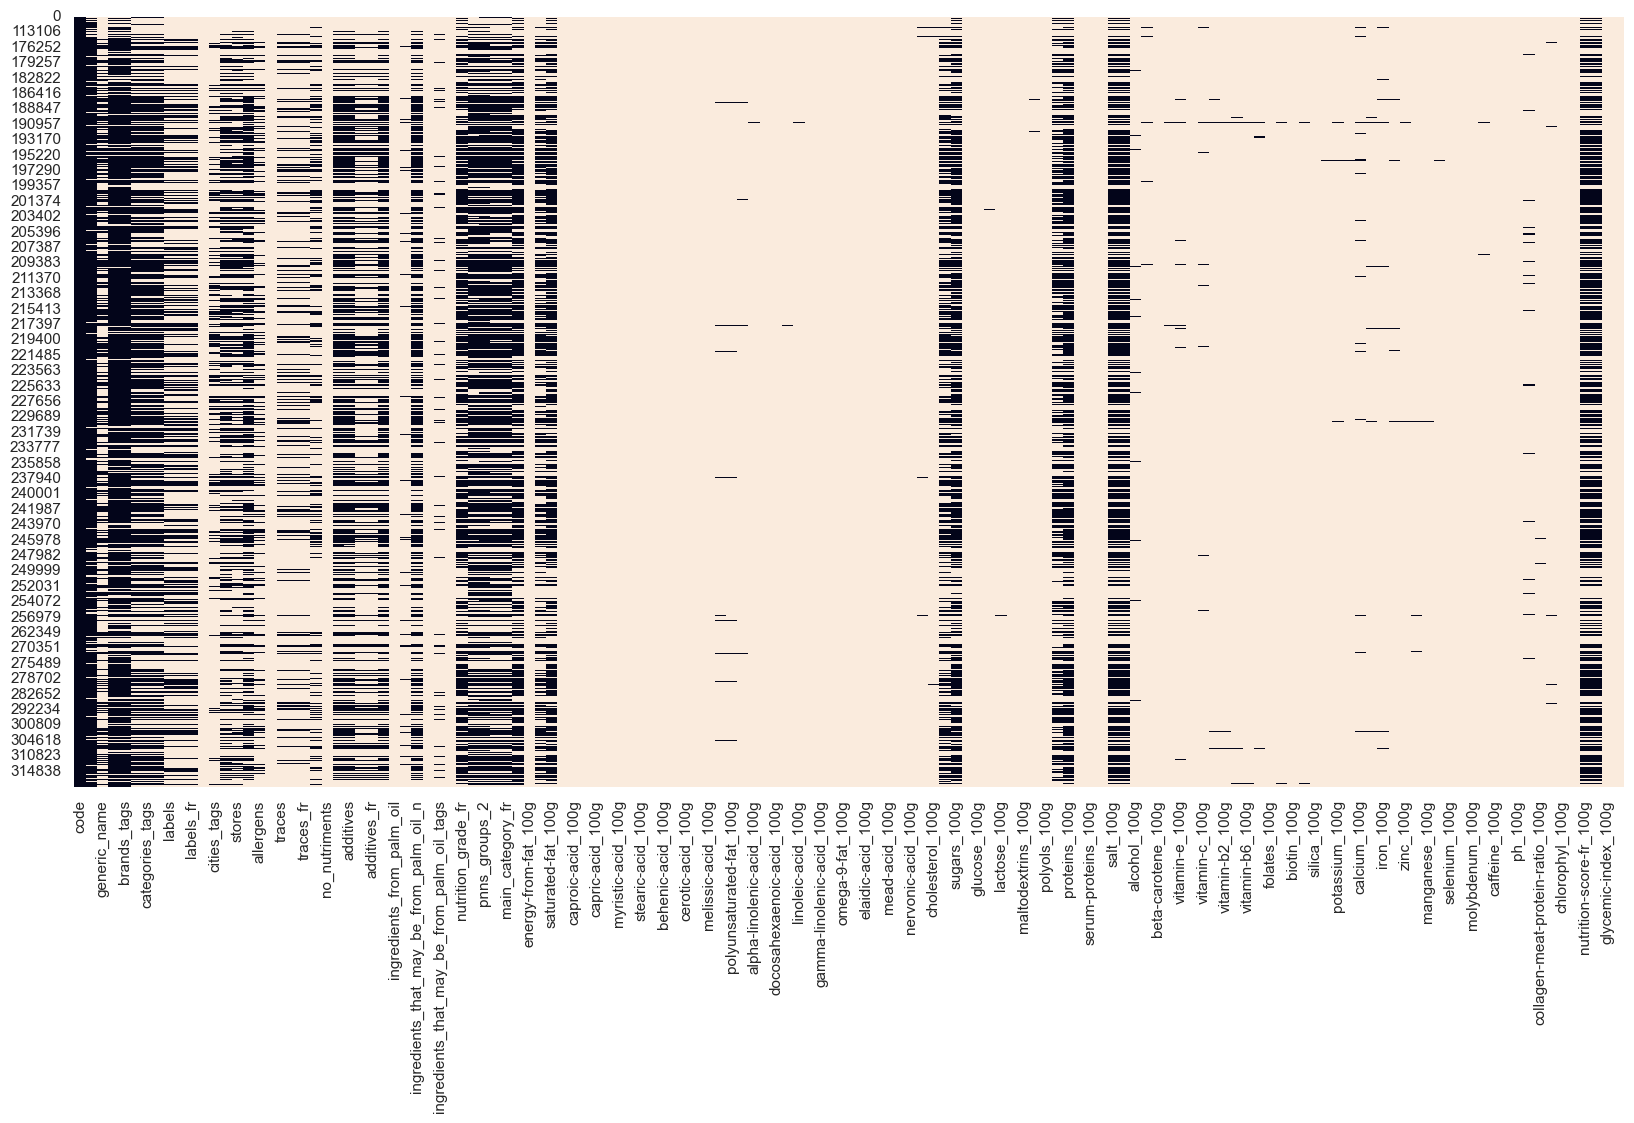

In [31]:
print("-------------------------------------------------------------")
print("Heatmap de visualisation des valeurs manquantes")
plt.figure(figsize=(20, 10))
sns.heatmap(data_fr.isna(), cbar=False)
plt.show()

## Répartition du pourcentage de valeurs manquantes pour toutes les variables provisoirement conservées

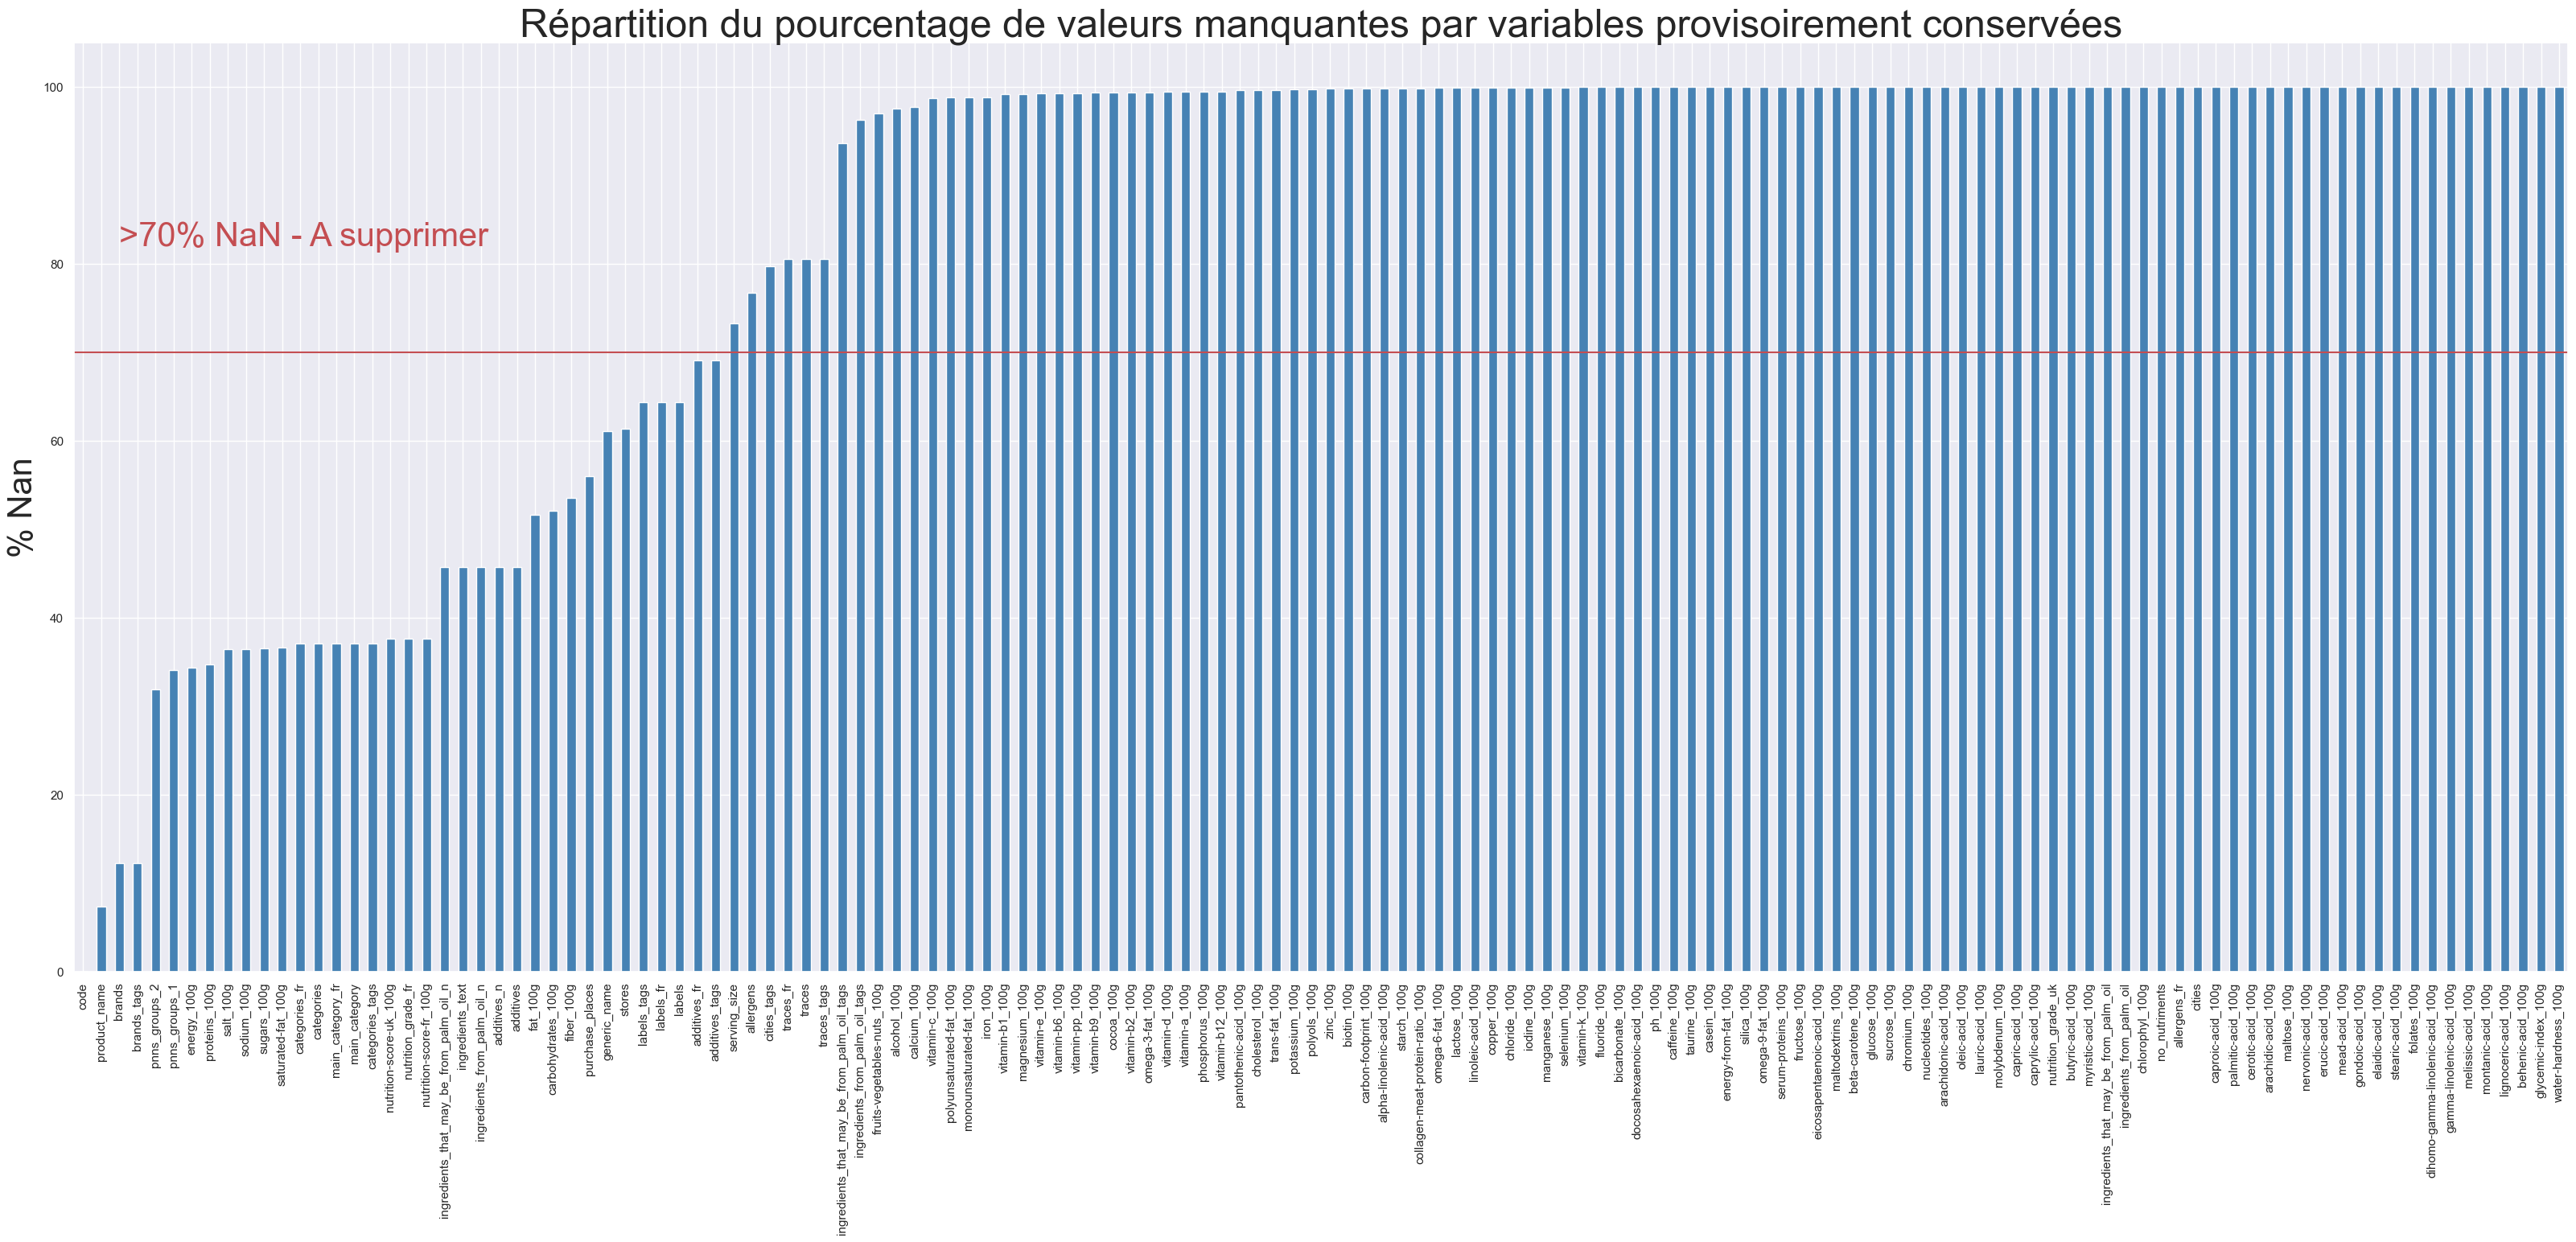

In [32]:
plt.figure(figsize=(40, 15))
data_retained_nan = round((data_fr.isna().sum()/data_fr.shape[0]) * 100, 2)
data_retained_nan.sort_values(inplace=True)
data_retained_nan.plot(kind='bar', color='SteelBlue')
plt.title('Répartition du pourcentage de valeurs manquantes par variables provisoirement conservées', fontsize=35)
plt.ylabel('% Nan', fontsize=30)
plt.axhline(y=70, color='r')
plt.text(2, 82, '>70% NaN - A supprimer', color='r', fontsize=30)
plt.show()

### Correction de synthaxe a effectuer avant le retrait des variables avec trop de valeurs manquantes.

In [33]:
# Correction de la synthaxe
car_avant = '-'
car_apres = '_'

cols_a_renommer = data_fr.columns[data_fr.columns.str.contains(car_avant)]
print(f"{len(cols_a_renommer)} variables renommées {car_avant} en {car_apres} : \n\n {cols_a_renommer.tolist()}")

data_fr.columns = data_fr.columns.str.replace(car_avant, car_apres)

56 variables renommées - en _ : 

 ['energy-from-fat_100g', 'saturated-fat_100g', 'butyric-acid_100g', 'caproic-acid_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'arachidic-acid_100g', 'behenic-acid_100g', 'lignoceric-acid_100g', 'cerotic-acid_100g', 'montanic-acid_100g', 'melissic-acid_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'alpha-linolenic-acid_100g', 'eicosapentaenoic-acid_100g', 'docosahexaenoic-acid_100g', 'omega-6-fat_100g', 'linoleic-acid_100g', 'arachidonic-acid_100g', 'gamma-linolenic-acid_100g', 'dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g', 'oleic-acid_100g', 'elaidic-acid_100g', 'gondoic-acid_100g', 'mead-acid_100g', 'erucic-acid_100g', 'nervonic-acid_100g', 'trans-fat_100g', 'serum-proteins_100g', 'vitamin-a_100g', 'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitami

### Nous allons egalement gerer les potentiels doublons.

In [34]:
def number_duplicates(dataframe, subset):
    
    # Marking all duplicates
    duplicates = dataframe.duplicated(subset=subset, keep=False)
    
    # If there are duplicated rows
    if True in list(duplicates.unique()):
        
        # Display and return number of duplicated rows
        result = len(dataframe[duplicates])
        print("There are {} duplicated rows.".format(result))
        return result
    
    # If there are no duplicated rows
    else:
        print("There are no duplicated rows.")
        return 0

In [35]:
subset = ["code"]

number_duplicates(data_fr, subset)

There are no duplicated rows.


0

### Gestion des valeurs manquantes par variable.

In [36]:
nb_lignes = data_fr.shape[0]
sum_nan = data_fr.isna().sum()

df_nan = pd.DataFrame({'Variable': sum_nan.index,
                           'nb_nan': sum_nan.values})

df_nan['%_nan'] = [(row * 100) / nb_lignes for row in df_nan['nb_nan']]
df_nan['%_nan_groupe'] = pd.cut(df_nan['%_nan'], bins=[0, 10, 20, 40, 60, 80, 100])
sum_gpe_nan = df_nan['%_nan_groupe'].value_counts().sort_index()

df_group_nan = pd.DataFrame({'Plage de %': sum_gpe_nan.index,
                              'nb_variable': sum_gpe_nan.values})



In [37]:
df_nan

,Variable,nb_nan,%_nan,%_nan_groupe
0,code,0,0.000000,NaN
1,product_name,7193,7.306989,"(0.0, 10.0]"
2,generic_name,60149,61.102194,"(60.0, 80.0]"
3,brands,12014,12.204388,"(10.0, 20.0]"
4,brands_tags,12018,12.208452,"(10.0, 20.0]"
...,...,...,...,...
133,carbon_footprint_100g,98264,99.821211,"(80.0, 100.0]"
134,nutrition_score_fr_100g,37025,37.611743,"(20.0, 40.0]"
135,nutrition_score_uk_100g,37025,37.611743,"(20.0, 40.0]"
136,glycemic_index_100g,98440,100.000000,"(80.0, 100.0]"


In [38]:
df_group_nan

,Plage de %,nb_variable
0,"(0, 10]",1
1,"(10, 20]",2
2,"(20, 40]",16
3,"(40, 60]",9
4,"(60, 80]",10
5,"(80, 100]",99


#### On remarque que  : 99 variables ont plus de 80% de valeurs manquantes.
#### 10 variables :  ont plus de 60% de valeurs manquantes.
#### Conclusion : comme explique plus haut, on procedera au retrait de ces variables

In [39]:
# Ajout d'un seuil pour retirer les donnees avec trop de valeurs manquantes > 60%
threshold = 0.4 * data_fr.shape[0]
data_fr_retained = data_fr.dropna(axis=1, thresh=threshold)

In [40]:
data_fr_retained.shape

(98440, 29)

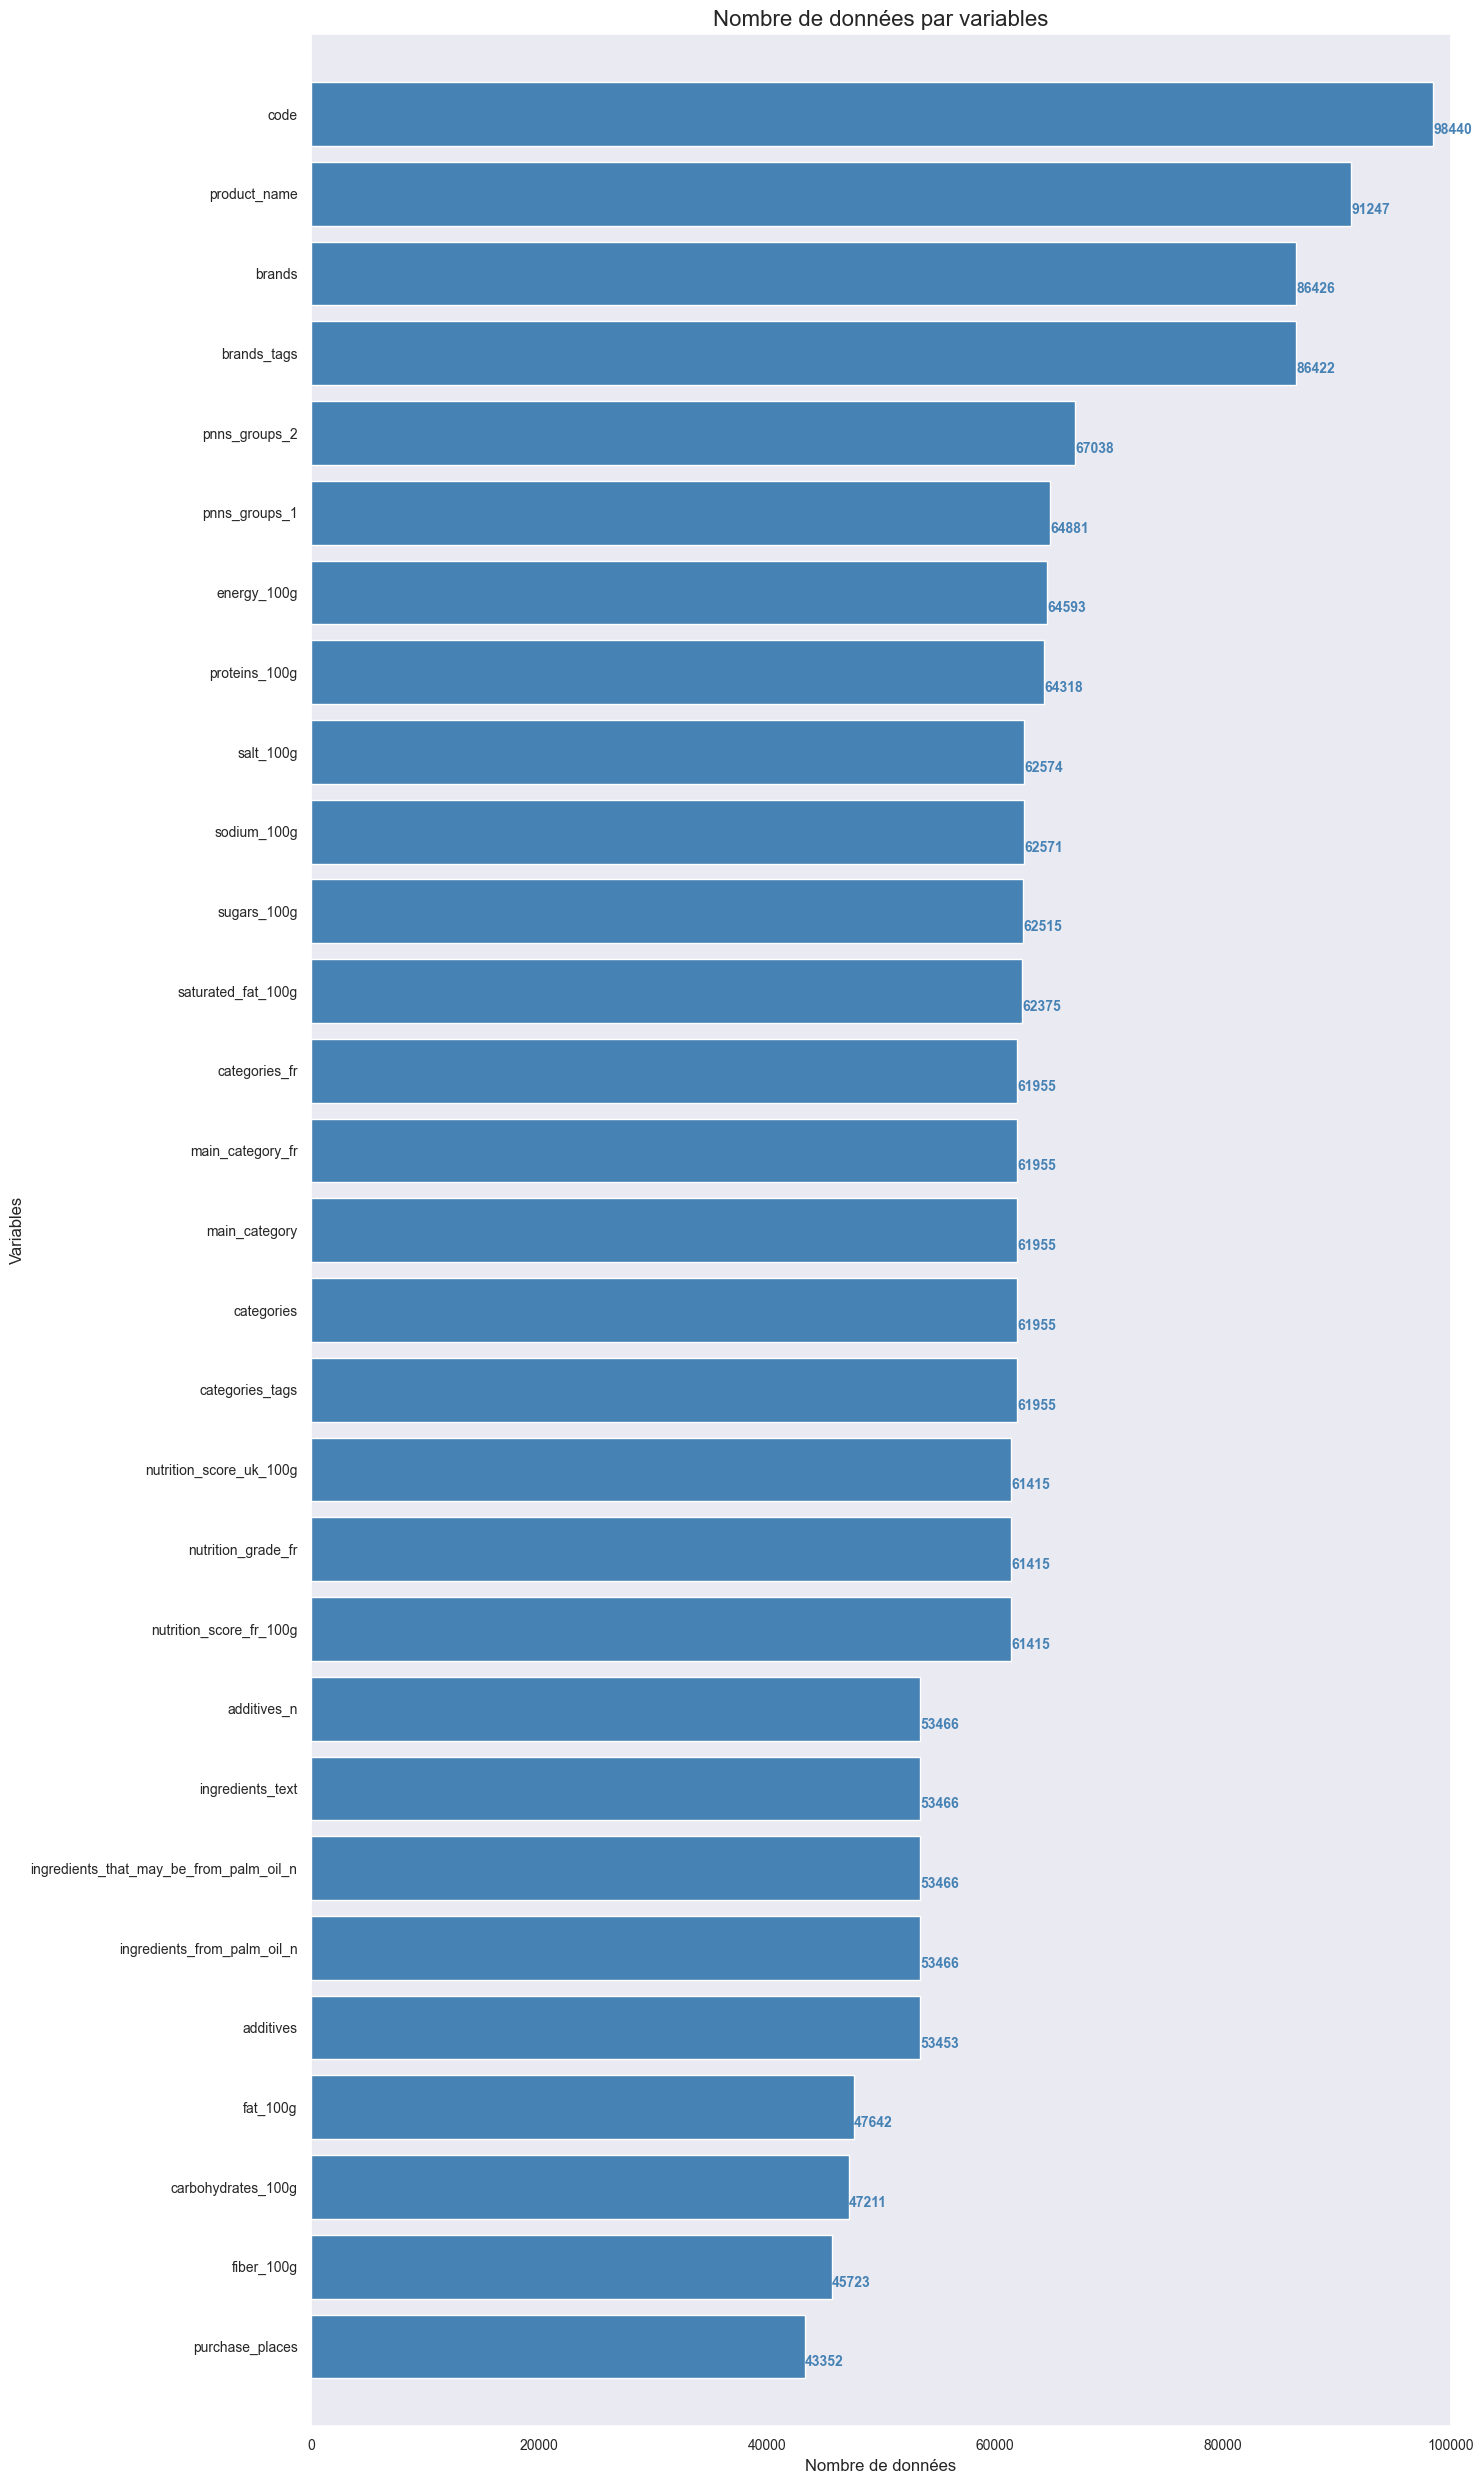

In [41]:
# Répartition des valeurs renseignées par variables
fig, ax = plt.subplots(figsize=(15, 25))

# Graphique ligne 1, colonne 1 ------------------
# Répartition des valeurs renseignées par variables
present = data_fr_retained.count()
present.sort_values(inplace=True)
ax.barh(y=present.index, width=present.values, color='SteelBlue')
for i, v in enumerate(present):
    ax.text(v + 5, i - .25, str(v), color='SteelBlue',
            fontsize=10, fontweight='bold')
ax.set_title('Nombre de données par variables', fontsize=16)
ax.set_xlabel('Nombre de données', fontsize=12)
ax.set_ylabel('Variables', fontsize=12)
ax.tick_params(labelsize=10)
ax.set_xlim([0, 100000])
ax.set_ylim([-1, 29])
ax.grid(False)
fig.tight_layout()
plt.show()

### Suppression supplementaire des varibales sans interets pour mon analyse personnelle et qui pourrait etre redondantes.

In [42]:
data_fr_retained = data_fr_retained.drop(['additives_n', 'additives', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n'], axis=1)

data_fr_retained_shape = data_fr_retained.shape
print(f"Le jeu de donnee contient {data_fr_retained_shape[0]} lignes et {data_fr_retained_shape[1]} colonnes.")

Le jeu de donnee contient 98440 lignes et 25 colonnes.


### Visualisons les variables encore presentes :

In [43]:
data_fr_retained.columns.tolist()

['code',
 'product_name',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'purchase_places',
 'ingredients_text',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'main_category',
 'main_category_fr',
 'energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition_score_fr_100g',
 'nutrition_score_uk_100g']

### Nous avons deja bien reduit le nombre de variables.

In [44]:
nb_rows, nb_columns = data_fr_retained.shape

# Count of the values on each column
columns_count = data_fr_retained.count()

# Sort the Series
columns_count = columns_count.sort_values(ascending=False)

# Calculating filling rates
filling_rates = columns_count / nb_rows

# Display a sampling (1 out of 10) of columns names and filling rates
filling_rates

code                       1.000000
product_name               0.926930
brands                     0.877956
brands_tags                0.877915
pnns_groups_2              0.681004
pnns_groups_1              0.659092
energy_100g                0.656166
proteins_100g              0.653373
salt_100g                  0.635656
sodium_100g                0.635626
sugars_100g                0.635057
saturated_fat_100g         0.633635
main_category_fr           0.629368
main_category              0.629368
categories_fr              0.629368
categories_tags            0.629368
categories                 0.629368
nutrition_grade_fr         0.623883
nutrition_score_fr_100g    0.623883
nutrition_score_uk_100g    0.623883
ingredients_text           0.543133
fat_100g                   0.483970
carbohydrates_100g         0.479592
fiber_100g                 0.464476
purchase_places            0.440390
dtype: float64

### Etat du dataframe.

The global filling rate of the DataFrame is : 65.21%


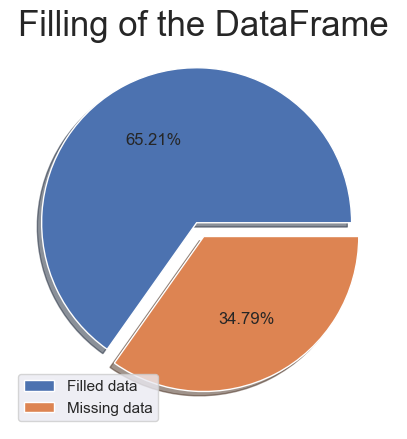

In [45]:
filling_rate(data_fr_retained)

In [46]:
data_fr_retained.head()

,code,product_name,brands,brands_tags,categories,categories_tags,categories_fr,purchase_places,ingredients_text,nutrition_grade_fr,...,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g,nutrition_score_uk_100g
0,0000000003087,Farine de blé noir,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,0000000024600,Filet de bœuf,NaN,NaN,Filet de bœuf,fr:filet-de-boeuf,Filet-de-boeuf,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,0000000027205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,0000000036252,Lion Peanut x2,Sunridge,sunridge,NaN,NaN,NaN,"Roissy,France","Milk chocolate coating (evaporated cane juice,...",e,...,20.0,12.5,70.0,57.5,2.5,2.5,0.09652,0.038,22.0,22.0
136,0000000039259,Twix x2,NaN,NaN,NaN,NaN,NaN,"Roissy,France",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Verifiions la colonne "energy_100g".

In [47]:
data_fr_retained['energy_100g'].describe()

count    6.459300e+04
mean     1.171553e+03
std      1.283590e+04
min      0.000000e+00
25%      4.270000e+02
50%      1.035000e+03
75%      1.649000e+03
max      3.251373e+06
Name: energy_100g, dtype: float64

c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


212928    3251373.0
219302      69292.0
223318      15481.0
245311      18700.0
249101     182764.0
Name: energy_100g, dtype: float64

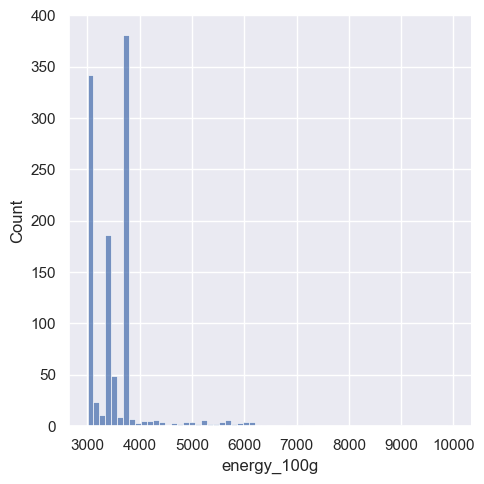

In [48]:
sns.displot(data_fr_retained[(data_fr_retained['energy_100g'] > 3000) & (data_fr_retained['energy_100g'] < 10000)]['energy_100g'])
data_fr_retained[data_fr_retained['energy_100g'] > 10000]['energy_100g']

### Il semblerait que les valeurs correspondent a la valeur energetique du produit. Au vu des valeurs presentes, l'unite est certainement des KiloJoules.

## On peut proceder a une conversion de la valeur energetique, de KJ en KC (KiloCalories) pour faciliter la lecture des valeurs.
### 1 KC = 4.184 KJ
### On peut egalement proceder a la mise en place d'une limite pour les outliers a ~ 936 KC car l'energie theorique maximale d'un produit est de 3700 KJ. Si on augmente a 4000 KJ cela donne ~ 936 KC.

In [49]:
print(data_fr_retained['energy_100g'].isna().sum())
print(data_fr_retained['energy_100g'].isnull().sum())

33847
33847


### Nous constatons qu'il reste des valeurs NaN dans la variable.

In [50]:
data_fr_retained['energy_100g'] = (data_fr_retained['energy_100g'] / 4.184)

In [51]:
data_fr_retained['energy_100g'].where(data_fr_retained['energy_100g'] >= 0, inplace=True)
data_fr_retained['energy_100g'].where(data_fr_retained['energy_100g'] <= 936, inplace=True)

In [52]:
data_fr_retained['energy_100g'].describe()

count    64509.000000
mean       265.725544
std        184.952647
min          0.000000
25%        102.055449
50%        246.892925
75%        393.881453
max        934.990440
Name: energy_100g, dtype: float64

### Information generales de la variable

In [53]:
print(data_fr_retained['energy_100g'].isna().sum())
print(data_fr_retained['energy_100g'].isnull().sum())
print(data_fr_retained['energy_100g'].shape)
print((data_fr_retained['energy_100g'].isna().sum())/(data_fr_retained['energy_100g'].shape[0])*100)

33931
33931
(98440,)
34.46871190572938


### ~34% de valeurs sont manquantes. Nous verrons par la suite quelle methode utiliser pour completer ces valeurs manquantes. L'utilisation de la moyenne est a eviter. Utiliser la medianne peut etre optionnel car elle est assez robuste aux outliers.
### L'imputation par un KNN semble plutot bon puisque l'energy depend des relations avec les autres variables (nutriments).
### Nous pourrions egalement utiliser un SimpleImputer base sur la mediane.

In [54]:
variance_energy = data_fr_retained['energy_100g'].var()
print(f"Variance de 'energy_100g' : {variance_energy}")

Variance de 'energy_100g' : 34207.48153122831


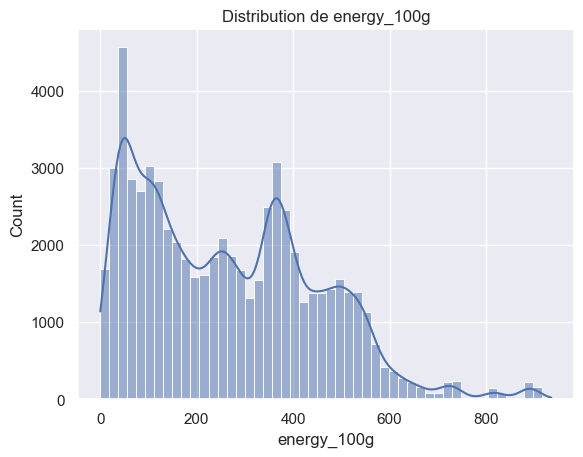

In [55]:
sns.histplot(data_fr_retained['energy_100g'], bins=50, kde=True)
plt.title("Distribution de energy_100g")
plt.show()

### On constate que la distribution est plutot de type bi_modale donc elle ne suit pas une loi normale. Il faudra etre vigileant apres imputation des valeurs manquantes.

## Retour sur le traitement de certaines variables categorielles

In [56]:
data_fr_retained.columns.tolist()

['code',
 'product_name',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'purchase_places',
 'ingredients_text',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'main_category',
 'main_category_fr',
 'energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition_score_fr_100g',
 'nutrition_score_uk_100g']

#### Afficher le nombre de valeurs manquantes par colonne

In [57]:
data_fr_retained.apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False)

purchase_places            55088
fiber_100g                 52717
carbohydrates_100g         51229
fat_100g                   50798
ingredients_text           44974
nutrition_score_uk_100g    37025
nutrition_grade_fr         37025
nutrition_score_fr_100g    37025
main_category_fr           36485
main_category              36485
categories_fr              36485
categories_tags            36485
categories                 36485
saturated_fat_100g         36065
sugars_100g                35925
sodium_100g                35869
salt_100g                  35866
proteins_100g              34122
energy_100g                33931
pnns_groups_1              33559
pnns_groups_2              31402
brands_tags                12018
brands                     12014
product_name                7193
code                           0
dtype: int64

####  Pourcentage des valeurs manquantes

In [58]:
nan_tot =  data_fr_retained.isna().sum().sum()
data_tot = np.product(data_fr_retained.shape)
percentage = round((nan_tot / data_tot) * 100, 2)
print(f'Valeurs manquantes :{nan_tot} NaN pour {data_tot} données ({percentage} %)')

Valeurs manquantes :856270 NaN pour 2461000 données (34.79 %)


In [59]:
data_fr_retained.dtypes

code                         object
product_name                 object
brands                       object
brands_tags                  object
categories                 category
categories_tags            category
categories_fr              category
purchase_places              object
ingredients_text             object
nutrition_grade_fr         category
pnns_groups_1                object
pnns_groups_2                object
main_category                object
main_category_fr             object
energy_100g                 float64
fat_100g                    float64
saturated_fat_100g          float64
carbohydrates_100g          float64
sugars_100g                 float64
fiber_100g                  float64
proteins_100g               float64
salt_100g                   float64
sodium_100g                 float64
nutrition_score_fr_100g     float64
nutrition_score_uk_100g     float64
dtype: object

## Transformation des types object en category si le nombre de modalite est inferieur au nombre de ligne

In [60]:
for col in data_fr_retained.columns.values:
    if data_fr_retained[col].dtype == 'object':
        #print(data_fr_retained[col].unique())
        print('Colonne : ', col)
        if len(data_fr_retained[col].unique()) / len(data_fr_retained[col]) < 0.5:
            data_fr_retained[col] = data_fr_retained[col].astype('category')

Colonne :  code
Colonne :  product_name
Colonne :  brands
Colonne :  brands_tags
Colonne :  purchase_places
Colonne :  ingredients_text
Colonne :  pnns_groups_1
Colonne :  pnns_groups_2
Colonne :  main_category
Colonne :  main_category_fr


## Suppression des produits sans noms ou avec un nom inferieur a une taille de 2. On ne pourra pas les re creer ou les deviner.

In [61]:
data_fr_retained.shape

(98440, 25)

In [62]:
data_fr_retained.dropna(subset=['product_name'], inplace=True)
data_fr_retained.shape

(91247, 25)

In [63]:
data_fr_retained.drop(data_fr_retained[data_fr_retained['product_name'].str.len() < 2].index, inplace=True)
data_fr_retained.shape

(91239, 25)

In [64]:
data_fr_retained_shape = data_fr_retained.shape
print(f"Le jeu de donnee contient {data_fr_retained_shape[0]} lignes et {data_fr_retained_shape[1]} colonnes.")

Le jeu de donnee contient 91239 lignes et 25 colonnes.


## Correction de la synthaxe sur les differents groupes PNN GROUPS 1 et 2

### Remplacement des tirets '-' dans le groupe par un esapce simple

In [65]:
data_fr_retained['pnns_groups_1'] = data_fr_retained['pnns_groups_1'].str.replace('-', " ")

### Normaliser tout en minuscule

In [66]:
data_fr_retained['pnns_groups_1'] = data_fr_retained['pnns_groups_1'].str.lower().apply(str)

In [67]:
data_fr_retained['pnns_groups_1'].sort_values().unique().tolist()

['beverages',
 'cereals and potatoes',
 'composite foods',
 'fat and sauces',
 'fish meat eggs',
 'fruits and vegetables',
 'milk and dairy products',
 'nan',
 'salty snacks',
 'sugary snacks',
 'unknown']

### Traduction de certains nom de groupe en Francais

In [68]:
dico_trad_grp1 = {'beverages': 'boissons',
                  'cereals and potatoes': 'cereales et pommes de terre',
                  'composite foods': 'aliments composes',
                  'fat and sauces': 'matieres grasses et les sauces',
                  'fish meat eggs': 'poisson viande oeufs',
                  'fruits and vegetables': 'fruits et legumes',
                  'milk and dairy products': 'lait et les produits laitiers',
                  'nan': 'a renseigner',
                  'salty snacks': 'collation sales',
                  'sugary snacks': 'collation sucree',
                  'unknown': 'a renseigner'}

for cle, valeur in dico_trad_grp1.items():
    data_fr_retained['pnns_groups_1'] = data_fr_retained['pnns_groups_1'].replace(cle, valeur)

In [69]:
data_fr_retained['pnns_groups_1'].sort_values().unique().tolist()

['a renseigner',
 'aliments composes',
 'boissons',
 'cereales et pommes de terre',
 'collation sales',
 'collation sucree',
 'fruits et legumes',
 'lait et les produits laitiers',
 'matieres grasses et les sauces',
 'poisson viande oeufs']

### Meme chose pour le sous groupe de produit pnns_groups_2

In [70]:
data_fr_retained['pnns_groups_2'] = data_fr_retained['pnns_groups_2'].str.replace('-', " ")

In [71]:
data_fr_retained['pnns_groups_2'] = data_fr_retained['pnns_groups_2'].str.lower().apply(str)

In [72]:
data_fr_retained['pnns_groups_2'].unique().tolist()

['nan',
 'unknown',
 'legumes',
 'biscuits and cakes',
 'non sugared beverages',
 'sweetened beverages',
 'meat',
 'one dish meals',
 'soups',
 'chocolate products',
 'cheese',
 'sweets',
 'sandwich',
 'appetizers',
 'dressings and sauces',
 'dried fruits',
 'nuts',
 'breakfast cereals',
 'pizza pies and quiche',
 'fruits',
 'fruit juices',
 'fats',
 'alcoholic beverages',
 'cereals',
 'vegetables',
 'bread',
 'processed meat',
 'ice cream',
 'fish and seafood',
 'pastries',
 'milk and yogurt',
 'dairy desserts',
 'tripe dishes',
 'artificially sweetened beverages',
 'fruit nectars',
 'potatoes',
 'eggs',
 'salty and fatty products']

In [73]:
dico_trad_grp2 = {'alcoholic beverages': 'boissons alcoolisees',
                  'appetizers': 'aperitifs',
                  'artificially sweetened beverages': 'boissons sucrees artificiellement',
                  'biscuits and cakes': 'biscuits et gateaux',
                  'bread': 'pain',
                  'breakfast cereals': 'cereales pour le petit dejeuner',
                  'cereals': 'cereales',
                  'cheese': 'fromage',
                  'chocolate products': 'produits a base de chocolat',
                  'dairy desserts': 'desserts laitiers',
                  'dressings and sauces': 'vinaigrettes et sauces',
                  'dried fruits': 'fruits secs',
                  'eggs': 'oeufs',
                  'fats': 'matieres grasses',
                  'fish and seafood': 'poissons et fruits de mer',
                  'fruit juices': 'jus de fruits',
                  'fruit nectars': 'nectars de fruits',
                  'ice cream': 'glaces',
                  'legumes': 'legumineuses',
                  'meat': 'viande',
                  'milk and yogurt': 'lait et yaourt',
                  'nan': 'a renseigner',
                  'nuts': 'noix',
                  'offals': 'abats',
                  'one-dish meals': 'repas a un plat',
                  'pastries': 'patisseries',
                  'pizza pies and quiches': 'pizzas et quiches',
                  'plant-based milk substitutes': 'substituts de lait a base de plantes',
                  'potatoes': 'pommes de terre',
                  'processed meat': 'viande transformee',
                  'salty and fatty products': 'produits sales et gras',
                  'sandwiches': 'sandwiches',
                  'soups': 'soupes',
                  'sweetened beverages': 'boissons sucrees',
                  'sweets': 'sucreries',
                  'teas and herbal teas and coffees': 'thes tisanes cafes',
                  'unsweetened beverages': 'boissons non sucrees',
                  'vegetables': 'legumes',
                  'waters and flavored waters': 'eaux et eaux aromatisees',
                  'unknown': 'a renseigner'}

for cle, val in dico_trad_grp2.items():
    data_fr_retained['pnns_groups_2'] = data_fr_retained['pnns_groups_2'].replace(cle, val)

In [74]:
data_fr_retained.columns.tolist()

['code',
 'product_name',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'purchase_places',
 'ingredients_text',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'main_category',
 'main_category_fr',
 'energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition_score_fr_100g',
 'nutrition_score_uk_100g']

In [75]:
data_fr_retained_shape = data_fr_retained.shape
print(f"Le jeu de donnee contient {data_fr_retained_shape[0]} lignes et {data_fr_retained_shape[1]} colonnes.")

Le jeu de donnee contient 91239 lignes et 25 colonnes.


In [76]:
# Afficher le nombre de valeurs manquantes par colonne
data_fr_retained.apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False)

purchase_places            48062
fiber_100g                 45739
carbohydrates_100g         44382
fat_100g                   43949
ingredients_text           37841
nutrition_score_uk_100g    30167
nutrition_grade_fr         30167
nutrition_score_fr_100g    30167
main_category_fr           29768
main_category              29768
categories_fr              29768
categories_tags            29768
categories                 29768
saturated_fat_100g         29216
sugars_100g                29083
sodium_100g                29027
salt_100g                  29024
proteins_100g              27291
energy_100g                27100
brands_tags                 5849
brands                      5845
pnns_groups_1                  0
pnns_groups_2                  0
product_name                   0
code                           0
dtype: int64

### Certaines variables sont encore incompletes. Retrait des variables non pertinente : purchase_places, ingredients_text

In [77]:
data_fr_retained.drop(['purchase_places', 'ingredients_text'], axis=1, inplace=True)

In [78]:
data_fr_retained.describe(include='all')

,code,product_name,brands,brands_tags,categories,categories_tags,categories_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,...,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g,nutrition_score_uk_100g
count,91239,91239,85394,85390,61471,61471,61471,61072,91239,91239,...,47290.000000,62023.000000,46857.000000,62156.000000,45500.000000,63948.000000,62215.000000,62212.000000,61072.000000,61072.000000
unique,91239,74360,20883,16099,26503,15545,15545,5,10,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,0000000003087,Huile d'olive vierge extra,Carrefour,carrefour,"Snacks sucrés,Biscuits et gâteaux,Biscuits","en:sugary-snacks,en:biscuits-and-cakes,en:bisc...","Snacks sucrés,Biscuits et gâteaux,Biscuits",d,a renseigner,a renseigner,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,62,2820,2958,291,579,579,16907,39105,37028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.330031,5.425187,27.741972,13.424597,2.559569,7.763841,1.160091,0.456749,8.678543,8.358036
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.930537,8.539554,27.417070,19.082011,4.642360,7.893419,4.303711,1.694356,9.044405,9.383227
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000,0.000000,0.000000,-15.000000,-15.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.300000,0.300000,4.000000,1.000000,0.000000,1.800000,0.080000,0.031496,1.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.800000,2.000000,14.500000,4.100000,1.300000,6.000000,0.558800,0.220000,9.000000,7.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.000000,7.400000,53.000000,17.800000,3.200000,11.000000,1.244600,0.490000,15.000000,16.000000


### Focus sur la variable 'Fiber_100g'. 
##### Le calcul de la presence de fibre dans un produit alimentaire est difficle a obtenir si la valeur est absente puisque la valeur est calculee en laboratoire par une methode appellee 'enzymatique gravimétrique'. J'opte pour le remplacement des valeurs NaN par '0'. Lui attribuer une valeur moyenne/medianne serait pas forcement juste.

In [79]:
data_fr_retained['fiber_100g'] = data_fr_retained['fiber_100g'].fillna(0)

In [80]:
data_fr_retained.describe()

,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g,nutrition_score_uk_100g
count,64139.000000,47290.000000,62023.000000,46857.000000,62156.000000,91239.000000,63948.000000,62215.000000,62212.000000,61072.000000,61072.000000
mean,265.702219,13.330031,5.425187,27.741972,13.424597,1.276432,7.763841,1.160091,0.456749,8.678543,8.358036
std,184.889921,16.930537,8.539554,27.417070,19.082011,3.519270,7.893419,4.303711,1.694356,9.044405,9.383227
min,0.000000,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000,0.000000,0.000000,-15.000000,-15.000000
25%,102.055449,1.300000,0.300000,4.000000,1.000000,0.000000,1.800000,0.080000,0.031496,1.000000,0.000000
50%,246.892925,6.800000,2.000000,14.500000,4.100000,0.000000,6.000000,0.558800,0.220000,9.000000,7.000000
75%,393.642447,21.000000,7.400000,53.000000,17.800000,1.300000,11.000000,1.244600,0.490000,15.000000,16.000000
max,934.990440,380.000000,210.000000,190.000000,105.000000,178.000000,100.000000,211.000000,83.000000,40.000000,36.000000


In [81]:
data_fr_retained_shape = data_fr_retained.shape
print(f"Le jeu de donnee contient {data_fr_retained_shape[0]} lignes et {data_fr_retained_shape[1]} colonnes.")

Le jeu de donnee contient 91239 lignes et 23 colonnes.


## Faisons un passage sur la correction des valeurs aberrantes

#### Suppression si energy_100g > 936 kcalories (limite fixee plus haute)
#### Lipides sont les nutriments les plus denses et 100g de lipides = 900 kcalories.

In [82]:
data_fr_retained['energy_100g'] = [np.nan if val > 936 else val for val in data_fr_retained['energy_100g']]

data_fr_retained.shape

(91239, 23)

In [83]:
data_fr_retained.describe()

,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g,nutrition_score_uk_100g
count,64139.000000,47290.000000,62023.000000,46857.000000,62156.000000,91239.000000,63948.000000,62215.000000,62212.000000,61072.000000,61072.000000
mean,265.702219,13.330031,5.425187,27.741972,13.424597,1.276432,7.763841,1.160091,0.456749,8.678543,8.358036
std,184.889921,16.930537,8.539554,27.417070,19.082011,3.519270,7.893419,4.303711,1.694356,9.044405,9.383227
min,0.000000,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000,0.000000,0.000000,-15.000000,-15.000000
25%,102.055449,1.300000,0.300000,4.000000,1.000000,0.000000,1.800000,0.080000,0.031496,1.000000,0.000000
50%,246.892925,6.800000,2.000000,14.500000,4.100000,0.000000,6.000000,0.558800,0.220000,9.000000,7.000000
75%,393.642447,21.000000,7.400000,53.000000,17.800000,1.300000,11.000000,1.244600,0.490000,15.000000,16.000000
max,934.990440,380.000000,210.000000,190.000000,105.000000,178.000000,100.000000,211.000000,83.000000,40.000000,36.000000


### Suppression de la ligne si la valeurs nutritionnelles d'un produit(pour 100g) > 100g ou < 0g

In [84]:
cols_100g = data_fr_retained.columns[data_fr_retained.columns.str.endswith('_100g')].tolist()
cols_100g.remove('energy_100g')
cols_100g.remove('nutrition_score_fr_100g')
cols_100g.remove('nutrition_score_uk_100g')

for col in cols_100g:
    data_fr_retained[col] = [np.nan if val > 100 else np.nan if val < 0 else val for val in data_fr_retained[col]]

data_fr_retained.shape

(91239, 23)

### Suppression des valeurs ou la masse totale des glucides est inférieure à la masse de sucre

In [85]:
data_fr_retained = data_fr_retained.drop(data_fr_retained[data_fr_retained['carbohydrates_100g'] < data_fr_retained['sugars_100g']].index)

data_fr_retained.shape

(91140, 23)

### Suppression des valeurs ou la masse totale des lipides est inférieure à la masse des acides gras

In [86]:
data_fr_retained['saturated_fat_100g'] = [np.nan if row[0] < row[1] else row[1] for row in zip(data_fr_retained['fat_100g'], data_fr_retained['saturated_fat_100g'])]

data_fr_retained.shape

(91140, 23)

### Comparaison du Salt VS Sodium

Corrélation entre 'salt_100g' et 'sodium_100g': 0.9999999808036787


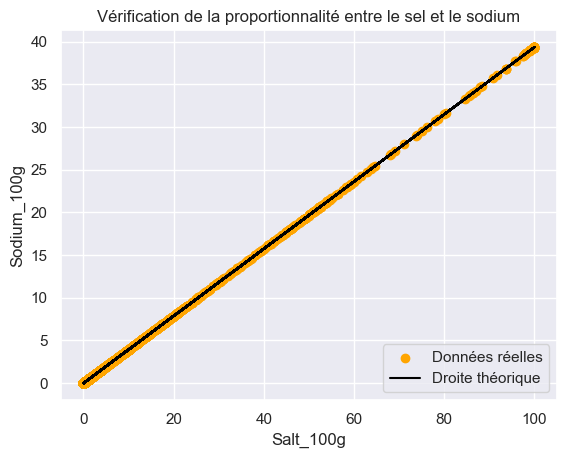

In [87]:
print(f"Corrélation entre 'salt_100g' et 'sodium_100g': {data_fr_retained['salt_100g'].corr(data_fr_retained['sodium_100g'])}")

plt.title('Vérification de la proportionnalité entre le sel et le sodium')
plt.scatter(data_fr_retained['salt_100g'], data_fr_retained['sodium_100g'], color='orange', label='Données réelles')
plt.plot(data_fr_retained['salt_100g'], data_fr_retained['salt_100g'] / 2.54, color='black', label='Droite théorique')
plt.xlabel('Salt_100g')
plt.ylabel('Sodium_100g')
plt.legend(loc='lower right')
plt.show()

### Supprimer les produits si 2,5 * sodium > sel (en g)

In [88]:
data_fr_retained = data_fr_retained.drop(data_fr_retained[data_fr_retained['sodium_100g'] > data_fr_retained['salt_100g']/2.4].index)

data_fr_retained.shape

(91140, 23)

### Regroupement des valeurs non nulles de la variable sodium_100g * 2.5 dans salt_100g et celle du sel dans une nouvelle variable

In [89]:
data_fr_retained['sel_100g'] = [row[0] if not np.isnan(row[0]) else row[1]*2.5 if not np.isnan(
    row[1]) else np.nan for row in zip(data_fr_retained['salt_100g'], data_fr_retained['sodium_100g'])]

data_fr_retained.shape

(91140, 24)

### Correction des valeurs aberrantes > 100g pour la nouvelle colonne sel_100g

In [90]:
data_fr_retained['sel_100g'] = [np.nan if val > 100 else val for val in data_fr_retained['sel_100g']]

data_fr_retained.shape

(91140, 24)

### Suppression des colonnes devenu inutile salt et sodium

In [91]:
data_fr_retained.drop('salt_100g', axis=1, inplace=True)
data_fr_retained.drop('sodium_100g', axis=1, inplace=True)

data_fr_retained.shape

(91140, 22)

In [92]:
data_fr_retained.describe()

,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,sel_100g
count,64040.000000,47191.000000,61843.000000,46751.000000,62053.000000,91139.000000,63849.000000,60974.000000,60974.000000,62114.000000
mean,265.770325,13.322007,5.418512,27.757842,13.416133,1.274938,7.760985,8.677748,8.356791,1.154574
std,184.912519,16.843038,8.484347,27.390833,19.065498,3.471497,7.890596,9.044331,9.383241,4.193799
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,-15.000000,0.000000
25%,102.055449,1.300000,0.300000,4.025000,1.000000,0.000000,1.800000,1.000000,0.000000,0.080000
50%,247.131931,6.800000,2.000000,14.500000,4.100000,0.000000,6.000000,9.000000,7.000000,0.558800
75%,393.881453,21.000000,7.400000,53.000000,17.700000,1.300000,11.000000,15.000000,16.000000,1.244600
max,934.990440,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,40.000000,36.000000,100.000000


### Suppresion de la ligne du produit si la somme des glucides + lipides + protéines + sel est supperieur a 100g (à 10% près)

In [93]:
data_fr_retained['temp'] = (data_fr_retained[['fat_100g', 'saturated_fat_100g']].max(axis=1)
               + data_fr_retained[['carbohydrates_100g', 'sugars_100g']].max(axis=1)
               + data_fr_retained['proteins_100g']
               + data_fr_retained['sel_100g'])

data_fr_retained.drop(data_fr_retained[data_fr_retained['temp'] > 110].index, inplace=True)

data_fr_retained.shape

(91080, 23)

### Suppression si calories > lipides * 9 + (glucides+proteines) * 4 + fibres * 1.9 (à 10% près)

In [94]:
data_fr_retained['temp'] = (9 * data_fr_retained['fat_100g'] + 
                             4 * (data_fr_retained['carbohydrates_100g'] + data_fr_retained['proteins_100g']) + 
                             1.9 * data_fr_retained['fiber_100g'])

data_fr_retained.drop(data_fr_retained[data_fr_retained['temp'] > 1.1 * data_fr_retained['energy_100g']].index, inplace=True)

data_fr_retained.shape

(89631, 23)

#### Suppression de la colonne temporaire 'temp'

In [95]:
data_fr_retained.drop('temp', axis=1, inplace=True)

In [96]:
data_fr_retained.describe(include='all')

,code,product_name,brands,brands_tags,categories,categories_tags,categories_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,...,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,sel_100g
count,89631,89631,83805,83801,60040,60040,60040,59633,89631,89631,...,62533.000000,45728.000000,60471.000000,45290.000000,60664.000000,89630.000000,62340.000000,59633.000000,59633.000000,60700.000000
unique,89631,73118,20553,15861,25992,15270,15270,5,10,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,0000000003087,Huile d'olive vierge extra,Carrefour,carrefour,"Snacks sucrés,Biscuits et gâteaux,Biscuits","en:sugary-snacks,en:biscuits-and-cakes,en:bisc...","Snacks sucrés,Biscuits et gâteaux,Biscuits",d,a renseigner,a renseigner,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,62,2777,2915,288,573,573,16647,38742,36667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,269.111644,13.538611,5.452809,27.716953,13.531757,1.245709,7.816439,8.769943,8.473815,1.143044
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,184.579318,16.896993,8.401915,27.247511,19.127707,3.273212,7.790942,9.044092,9.380021,4.041909
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.000000,-14.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,105.162524,1.500000,0.300000,4.100000,1.000000,0.000000,2.000000,1.000000,0.000000,0.080000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,250.956023,7.000000,2.000000,14.700000,4.100000,0.000000,6.000000,9.000000,8.000000,0.570000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,396.032505,21.500000,7.500000,53.000000,18.000000,1.300000,11.000000,16.000000,16.000000,1.250000


## Traitement des colonnes semblables

In [97]:
data_fr_retained.columns.tolist()

['code',
 'product_name',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'main_category',
 'main_category_fr',
 'energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'nutrition_score_fr_100g',
 'nutrition_score_uk_100g',
 'sel_100g']

In [98]:
categories = data_fr_retained[['categories', 'categories_tags', 'categories_fr', 'pnns_groups_1', 'pnns_groups_2', 'main_category', 'main_category_fr']]

In [99]:
print("Nombre de catégories différentes:")
for col in categories:
    print(f"{col} : {len(categories[col].value_counts())}")

Nombre de catégories différentes:
categories : 36982
categories_tags : 21142
categories_fr : 21152
pnns_groups_1 : 10
pnns_groups_2 : 37
main_category : 1615
main_category_fr : 1615


### 'pnns_groups_1' semble être le meilleur choix avec un nombre de catégories plus réduit, ce qui permettra éventuellement de faire des analyses dessus.

In [100]:
data_fr_retained['pnns_groups_1'].value_counts()

pnns_groups_1
a renseigner                      38742
collation sucree                   9509
poisson viande oeufs               6680
lait et les produits laitiers      6333
boissons                           6199
cereales et pommes de terre        6031
aliments composes                  5925
fruits et legumes                  4417
matieres grasses et les sauces     3696
collation sales                    2099
Name: count, dtype: int64

### Nouvelle reduction des variables a effectuer. Nous conservons PNNS GROUPS 1.

In [101]:
data_fr_retained.drop(['categories', 'categories_tags', 'categories_fr', 'pnns_groups_2', 'main_category', 'main_category_fr'], axis=1, inplace=True)

data_fr_retained_shape = data_fr_retained.shape
print(f"Le jeu de donnee contient {data_fr_retained_shape[0]} lignes et {data_fr_retained_shape[1]} colonnes.")

Le jeu de donnee contient 89631 lignes et 16 colonnes.


In [102]:
data_fr_retained.columns.tolist()

['code',
 'product_name',
 'brands',
 'brands_tags',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'nutrition_score_fr_100g',
 'nutrition_score_uk_100g',
 'sel_100g']

## Difference entre brand et brand_tags

In [103]:
data_fr_retained[['brands', 'brands_tags']].sample(10)

,brands,brands_tags
205338,Pâturages,paturages
237667,Carrefour,carrefour
186444,NaN,NaN
250669,les recettes de Céliane,les-recettes-de-celiane
182772,NaN,NaN
231126,Netto,netto
234620,Les 4 Saisons,les-4-saisons
433,Le Moulin de Moreau-Sarlat,le-moulin-de-moreau-sarlat
209159,Pressade,pressade
304778,SARF,sarf


In [104]:
print("Nombre de valeurs manquantes:")
for col in ['brands', 'brands_tags']:
    print(f"{col} : {sum(data_fr_retained[col].isnull())}")

Nombre de valeurs manquantes:
brands : 5826
brands_tags : 5830


##### Nous constatons un peu plus de valeurs manquantes sur la variable brands_tags. Retrait de cette variable et nous conservons brands.

In [105]:
data_fr_retained.drop(['brands_tags'], axis=1, inplace=True)

data_fr_retained.shape

(89631, 15)

### Comparaison entre les variables nutrition_score_fr_100g et nutrition_score_uk_100g.

In [106]:
mask = data_fr_retained['nutrition_score_fr_100g'] == data_fr_retained['nutrition_score_uk_100g']

print(f"Les 2 scores sont identiques dans "f"{len(data_fr_retained[mask])/data_fr_retained.shape[0]*100:.2f}% des cas")

Les 2 scores sont identiques dans 59.60% des cas


In [107]:
data_fr_retained[['nutrition_score_fr_100g', 'nutrition_score_uk_100g']].sample(10)

,nutrition_score_fr_100g,nutrition_score_uk_100g
298967,28.0,23.0
206403,18.0,18.0
308665,NaN,NaN
233221,NaN,NaN
195876,NaN,NaN
236601,NaN,NaN
250786,NaN,NaN
270972,6.0,6.0
317843,NaN,NaN
235455,0.0,0.0


In [108]:
print("Nombre de valeurs manquantes:")
for col in ['nutrition_score_fr_100g', 'nutrition_score_uk_100g']:
    print(f"{col} : {sum(data_fr_retained[col].isnull())}")

Nombre de valeurs manquantes:
nutrition_score_fr_100g : 29998
nutrition_score_uk_100g : 29998


#### Les deux variables sont semblables, nous allons partir du principe que nous avons travaille avec les produits du marche francais donc nous conserverons nutrition_score_fr_100g.

In [109]:
data_fr_retained.drop(['nutrition_score_uk_100g'], axis=1, inplace=True)

data_fr_retained.shape

(89631, 14)

## Verification des valeurs manquantes après les diverses corrections

In [110]:
values = data_fr_retained.isnull().sum()
percentage = 100 * values / len(data_fr_retained)
table = pd.concat([values, percentage.round(2)], axis=1)
table.columns = ['Nombres de valeurs manquantes', '% de valeurs manquantes']
table.loc[table['Nombres de valeurs manquantes'] != 0].sort_values('% de valeurs manquantes', ascending=False).style.background_gradient('Greens')

,Nombres de valeurs manquantes,% de valeurs manquantes
carbohydrates_100g,44341,49.470000
fat_100g,43903,48.980000
nutrition_grade_fr,29998,33.470000
nutrition_score_fr_100g,29998,33.470000
saturated_fat_100g,29160,32.530000
sugars_100g,28967,32.320000
sel_100g,28931,32.280000
proteins_100g,27291,30.450000
energy_100g,27098,30.230000
brands,5826,6.500000


-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


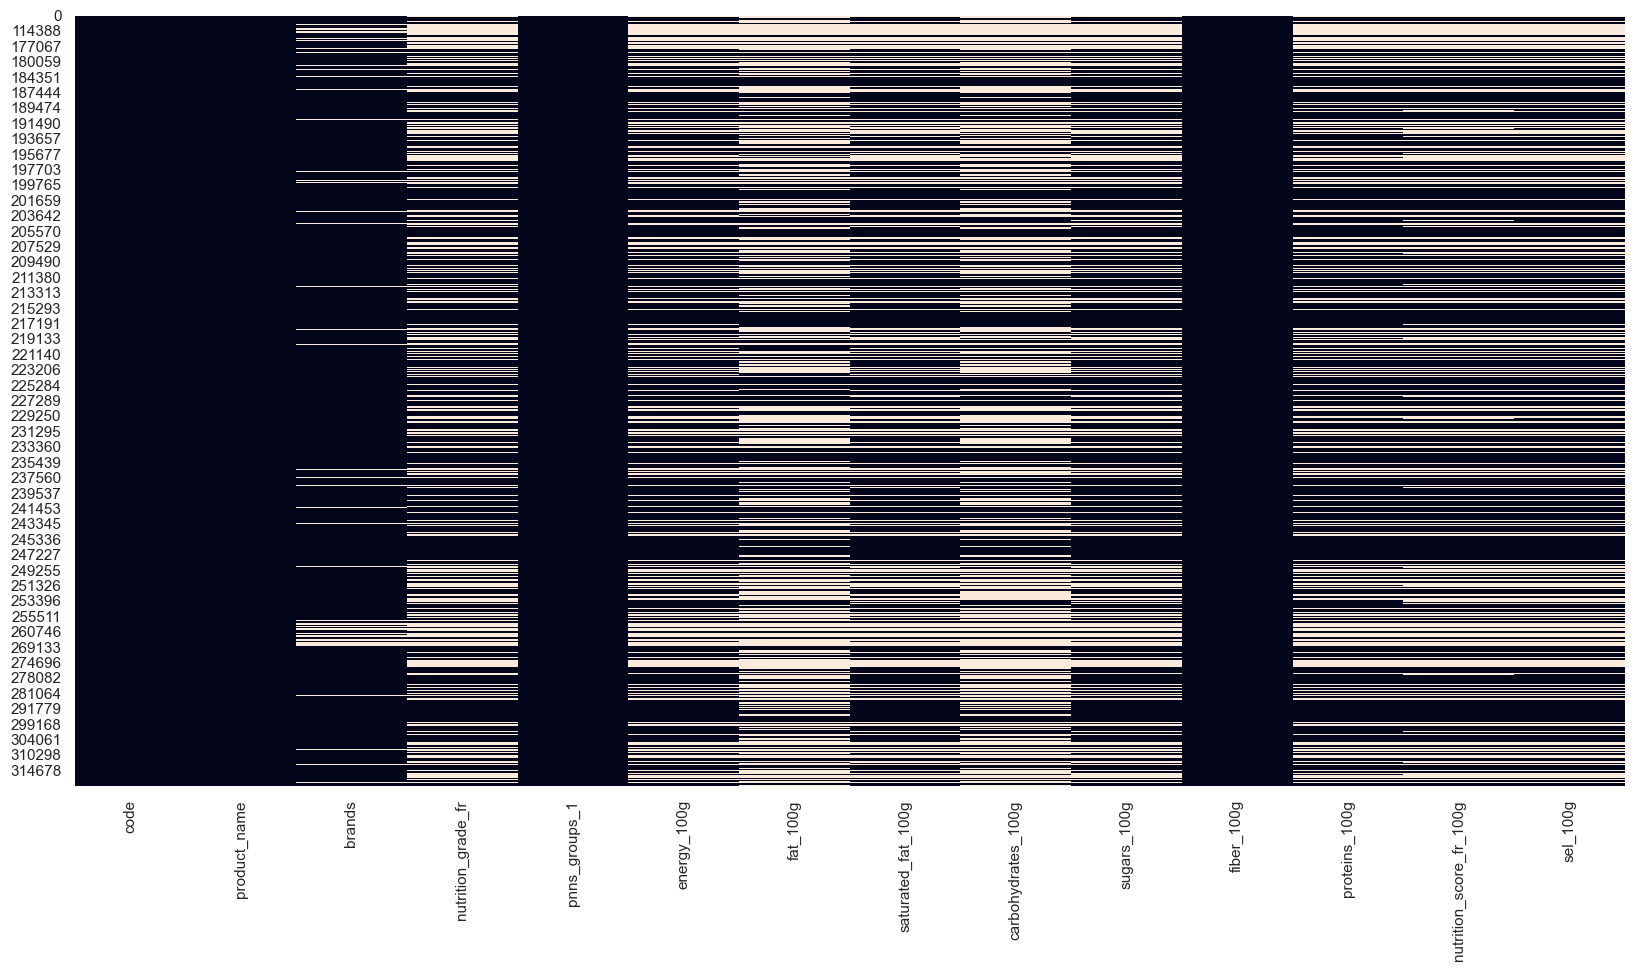

In [111]:
print("-------------------------------------------------------------")
print("Heatmap de visualisation des valeurs manquantes")
plt.figure(figsize=(20, 10))
sns.heatmap(data_fr_retained.isna(), cbar=False)
plt.show()

## Ajustement sur la variable nutrition_grade_fr

In [112]:
data_fr_retained['nutrition_grade_fr'].unique()

[NaN, 'e', 'd', 'c', 'a', 'b']
Categories (5, object): ['a' < 'b' < 'c' < 'd' < 'e']

In [113]:
data_fr_retained['nutrition_grade_fr'] = data_fr_retained['nutrition_grade_fr'].str.upper().apply(str)

In [114]:
data_fr_retained['nutrition_grade_fr'].unique()

array(['nan', 'E', 'D', 'C', 'A', 'B'], dtype=object)

In [115]:
data_fr_retained['nutrition_score_fr_100g'].describe()

count    59633.000000
mean         8.769943
std          9.044092
min        -14.000000
25%          1.000000
50%          9.000000
75%         16.000000
max         40.000000
Name: nutrition_score_fr_100g, dtype: float64

In [116]:
gb = data_fr_retained.groupby('nutrition_grade_fr')['nutrition_score_fr_100g']

df_nutriscore = pd.DataFrame([gb.get_group(n).values for n in list('ABCDE')], index=list('ABCDE')).T

In [117]:
def stat_descriptives(dataframe, liste_variables):
    """
    Statistiques descriptives moyenne, mediane, variance, écart-type,
    skewness et kurtosis du dataframe transmis en paramètre
    ----------
    @param IN : dataframe : DataFrame, obligatoire
                liste_variables : colonne dont on veut voir les stat descr
    @param OUT : dataframe des statistiques descriptives
    """
    liste_mean = ['mean']
    liste_median = ['median']
    liste_var = ['var']
    liste_std = ['std']
    liste_skew = ['skew']
    liste_kurtosis = ['kurtosis']
    liste_mode = ['mode']
    liste_cols = ['Desc']
    liste_max = ['Max']
    liste_min = ['Min']

    for col in liste_variables:
        liste_mean.append(dataframe[col].mean())
        liste_median.append(dataframe[col].median())
        liste_var.append(dataframe[col].var(ddof=0))
        liste_std.append(dataframe[col].std(ddof=0))
        liste_skew.append(dataframe[col].skew())
        liste_kurtosis.append(dataframe[col].kurtosis())
        liste_cols.append(col)
        liste_mode.append(dataframe[col].mode().to_string())
        liste_min.append(dataframe[col].min())
        liste_max.append(dataframe[col].max())

    data_stats = [liste_mean, liste_median, liste_var, liste_std, liste_skew, liste_kurtosis, liste_mode, liste_min, liste_max]
    df_stat = pd.DataFrame(data_stats, columns=liste_cols)

    return df_stat.style.hide()

In [118]:
stat_descriptives(df_nutriscore, ['A', 'B', 'C', 'D', 'E'])

Desc,A,B,C,D,E
mean,-3.608682,0.878591,5.703125,13.832162,21.426655
median,-3.000000,1.000000,5.000000,14.000000,21.000000
var,5.250461,0.897823,6.042490,6.345591,15.581704
std,2.291388,0.947535,2.458148,2.519046,3.947367
skew,-0.796917,-1.219741,0.449264,-0.317138,-0.515778
kurtosis,0.836486,6.108264,-1.156414,0.141738,0.801597
mode,0 -1.0,0 0.0,0 3.0,0 14.0,0 19.0
Min,-14.000000,-8.000000,2.000000,6.000000,10.000000
Max,10.000000,2.000000,10.000000,18.000000,40.000000


In [119]:
cond1 = data_fr_retained['nutrition_grade_fr'] == 'A'
cond2 = data_fr_retained['nutrition_score_fr_100g'] > 0
data_fr_retained[cond1 & cond2][['product_name', 'nutrition_grade_fr', 'nutrition_score_fr_100g']]

,product_name,nutrition_grade_fr,nutrition_score_fr_100g
180946,Pétillante saveur Citron,A,1.0
192052,Sans sucres Agrumes,A,1.0
192056,Evian,A,10.0
192065,La Salvetat Citron vert,A,1.0
192067,Badoit Citron,A,1.0
192073,Badoit Framboise,A,1.0
192119,La Salvetat Citron,A,1.0
198272,"Perrier citron vert, limoen",A,1.0
220374,Sémillante arômes naturels Citron,A,4.0
245670,Source St Jean,A,2.0


#### Les eaux peuvent avoir un nutriscore > -1 et une note A, conforme au calcul du nutriscore donc rien à corriger.

In [120]:
data_fr_retained_shape = data_fr_retained.shape
print(f"Le jeu de donnee contient {data_fr_retained_shape[0]} lignes et {data_fr_retained_shape[1]} colonnes.")

Le jeu de donnee contient 89631 lignes et 14 colonnes.


In [121]:
data_fr_retained

,code,product_name,brands,nutrition_grade_fr,pnns_groups_1,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,nutrition_score_fr_100g,sel_100g
0,0000000003087,Farine de blé noir,Ferme t'y R'nao,nan,a renseigner,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
46,0000000024600,Filet de bœuf,NaN,nan,a renseigner,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
106,0000000036252,Lion Peanut x2,Sunridge,E,a renseigner,450.047801,20.00,12.5,70.00,57.5,2.5,2.50,22.0,0.09652
136,0000000039259,Twix x2,NaN,nan,a renseigner,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
138,0000000039529,Pack de 2 Twix,"Twix, Lundberg",nan,a renseigner,353.967495,4.17,NaN,77.08,NaN,6.2,6.25,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320760,99044169,Poireaux,NaN,nan,a renseigner,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
320761,9906410000009,Roussette du Bugey (2011),Roussette du Bugey,nan,a renseigner,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
320764,9918,"Cheese cake thé vert, yuzu",NaN,nan,a renseigner,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
320765,9935010000003,Rillette d'oie,"Sans marque,D.Lambert",nan,poisson viande oeufs,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


### Verification des valeurs manquantes apres corrections

In [122]:
values = data_fr_retained.isnull().sum()
percentage = 100 * values / len(data_fr_retained)
table = pd.concat([values, percentage.round(2)], axis=1)
table.columns = ['Nombres de valeurs manquantes', '% de valeurs manquantes']
table.loc[table['Nombres de valeurs manquantes'] != 0].sort_values('% de valeurs manquantes', ascending=False).style.background_gradient('Greens')

,Nombres de valeurs manquantes,% de valeurs manquantes
carbohydrates_100g,44341,49.470000
fat_100g,43903,48.980000
nutrition_score_fr_100g,29998,33.470000
saturated_fat_100g,29160,32.530000
sugars_100g,28967,32.320000
sel_100g,28931,32.280000
proteins_100g,27291,30.450000
energy_100g,27098,30.230000
brands,5826,6.500000
fiber_100g,1,0.000000


In [123]:
data_fr_retained.columns.tolist()

['code',
 'product_name',
 'brands',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'nutrition_score_fr_100g',
 'sel_100g']

### On va maintenant regarder les correlations qu'il peut exister sur nos variables _100g afin de decider pour les imputations des valeurs manquantes restantes.

In [124]:
cols = data_fr_retained.select_dtypes(include=[np.number]).columns.to_list()

In [125]:
cols

['energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'nutrition_score_fr_100g',
 'sel_100g']

In [126]:
corr = data_fr_retained[cols].corr()

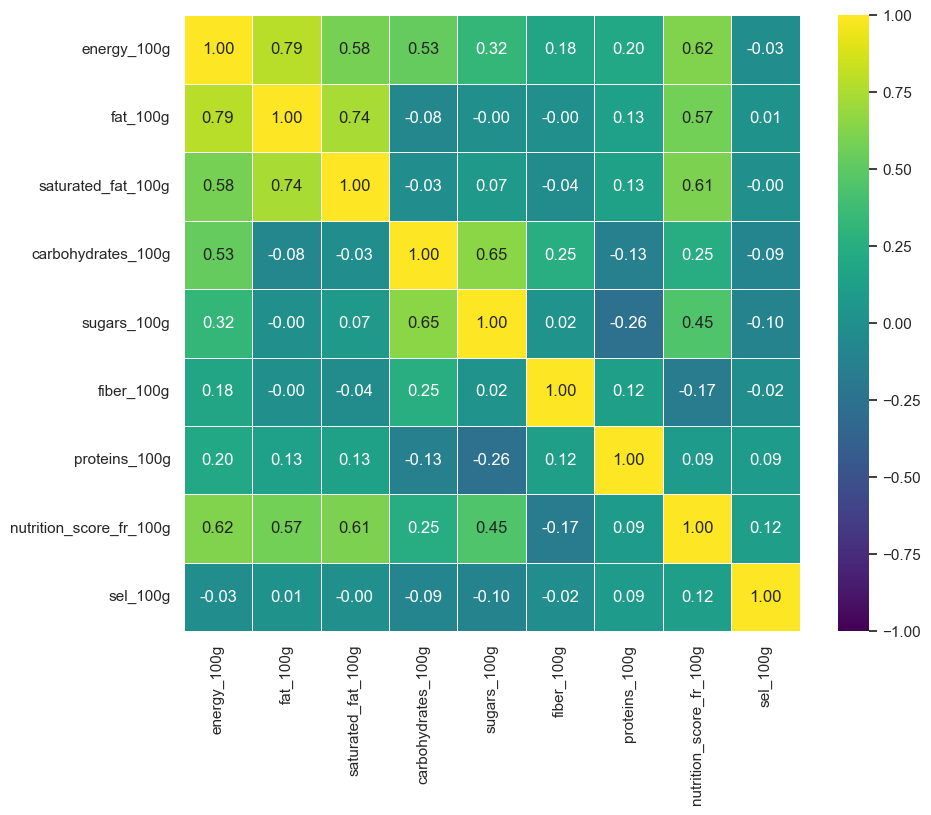

In [127]:
plt.figure(figsize = (10,8))
plt.rcParams.update({'font.size': 12})
sns.heatmap(corr, cmap = 'viridis', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5)
plt.show()

##### Correlations energy : 
#### nutrition_score_fr_100g / carbohydrates_100g / satured_fat_100g / fat_100g ( variables avec le plus de correlations. Ca sera la cible pour l'utilisation d'un KNN)

### En revanche pour les variables fat_100g / carbohydrate_100g je ne l'appliquerais pas dessus car 48% de valeurs manquantes remplacees par une mediane risque d'impacter fortement leur distribution et donc d'impacter la relations avec energy_100g. 
### Je prefere donc retirer les lignes absentes.

##### correlations fat : nutrition_score_fr_100g / satured_fat_100g / energy_100g
##### correlations carbohydrates : sugars_100g / energy_100g

### Concernant les variables suivantes ~30% (a cet instant) de valeurs manquantes.. je procederais a l'utilisations d'un SimpleImputer par la mediane.

##### correlations satured_fat : nutrition_score_fr_100g / fat_100g / energy_100g
##### correlations sugars : carbohydrates_100g
##### correlations fiber : peu corrélée (nous avions deja procede au remplacement par '0')
##### correlations proteins : peu corrélée
##### correlations nutritions_score : satured_fat_100g / fat_100g / energy_100g
##### correlations sel : peu corrélée

## Je vais retirer les valeurs manquantes des deux variables carbohydrates_100g et fat_100g

In [128]:
data_fr_retained = data_fr_retained.dropna(subset=['carbohydrates_100g', 'fat_100g'])

data_fr_retained.shape

(45062, 14)

In [130]:
values = data_fr_retained.isnull().sum()
percentage = 100 * values / len(data_fr_retained)
table = pd.concat([values, percentage.round(2)], axis=1)
table.columns = ['Nombres de valeurs manquantes', '% de valeurs manquantes']
table.loc[table['Nombres de valeurs manquantes'] != 0].sort_values('% de valeurs manquantes', ascending=False).style.background_gradient('Greens')

,Nombres de valeurs manquantes,% de valeurs manquantes
nutrition_score_fr_100g,2715,6.030000
saturated_fat_100g,1916,4.250000
sel_100g,1858,4.120000
sugars_100g,1850,4.110000
brands,215,0.480000
proteins_100g,116,0.260000
energy_100g,60,0.130000
fiber_100g,1,0.000000


## Imputation par SimpleImputer pour les variables ~30% de valeurs manquantes.

In [131]:
# Liste des colonnes à imputer
columns_to_impute = [
    'saturated_fat_100g', 
    'sugars_100g',
    'nutrition_score_fr_100g',
    'sel_100g'
]

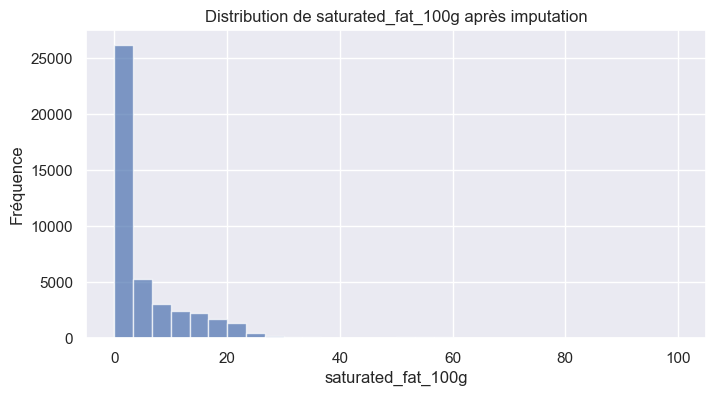

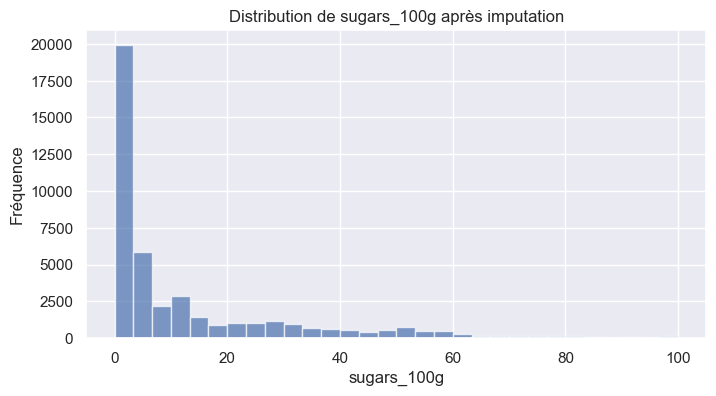

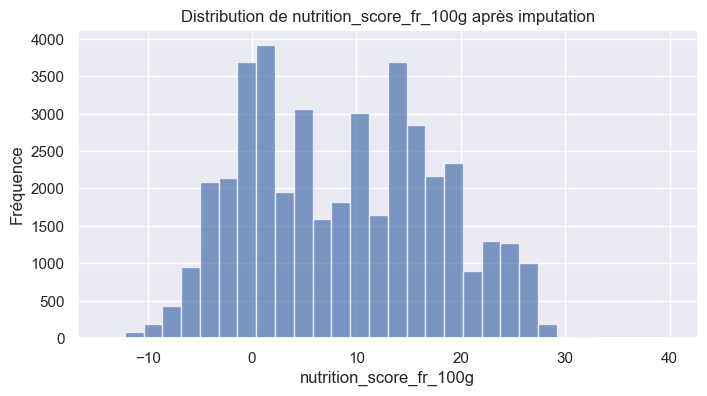

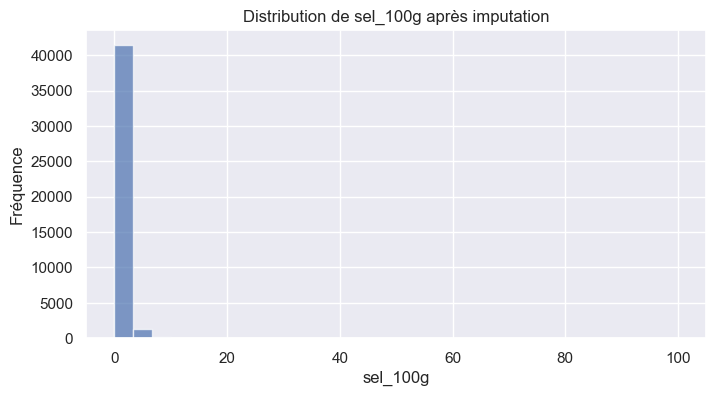

In [132]:
for col in columns_to_impute:
    plt.figure(figsize=(8, 4))
    data_fr_retained[col].hist(bins=30, alpha=0.7)
    plt.title(f"Distribution de {col} après imputation")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.show()

In [133]:
# Création de l'imputateur avec la stratégie 'median'
imputer = SimpleImputer(strategy='median')

In [135]:
# Application de l'imputateur sur les colonnes sélectionnées
data_fr_retained[columns_to_impute] = imputer.fit_transform(data_fr_retained[columns_to_impute])

C:\Users\cosic\AppData\Local\Temp\ipykernel_25580\1271966461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fr_retained[columns_to_impute] = imputer.fit_transform(data_fr_retained[columns_to_impute])


In [136]:
print(data_fr_retained[columns_to_impute].isnull().sum())

saturated_fat_100g         0
sugars_100g                0
nutrition_score_fr_100g    0
sel_100g                   0
dtype: int64


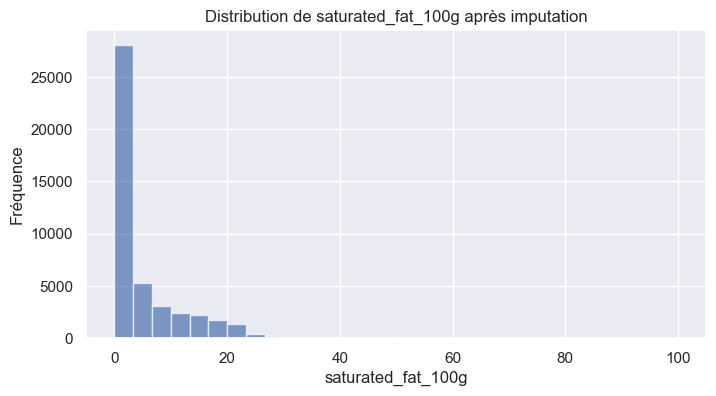

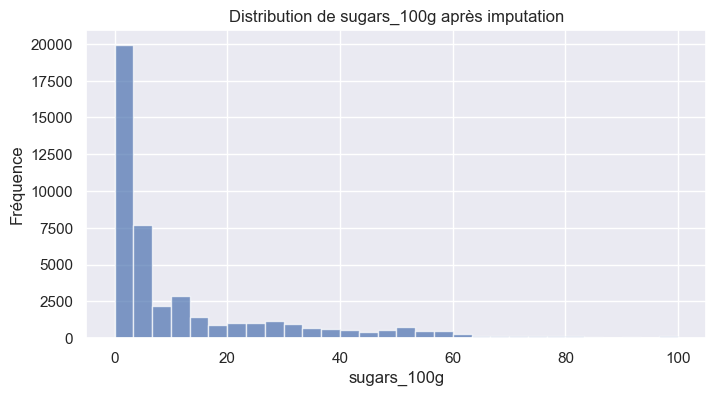

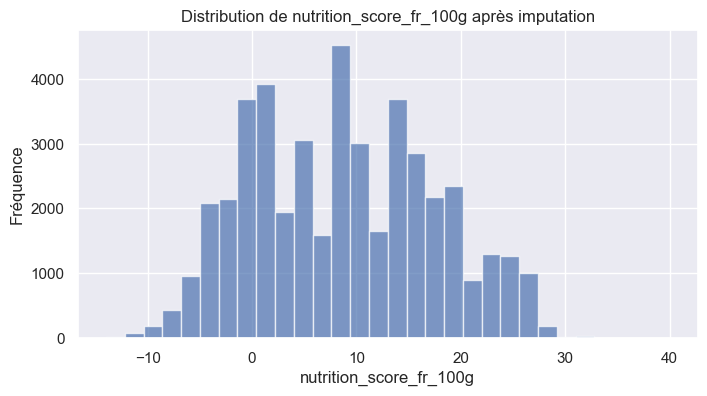

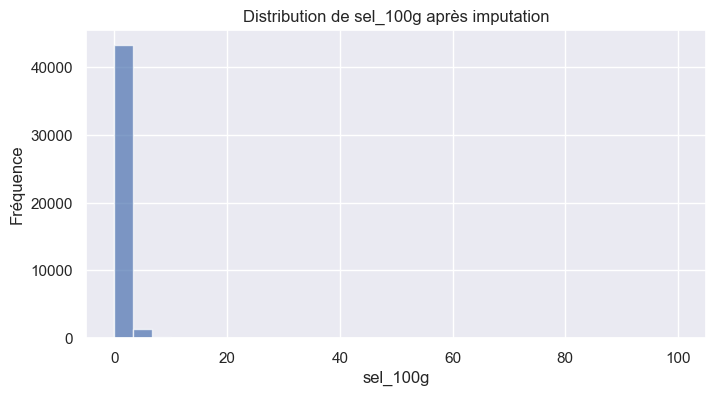

In [137]:
for col in columns_to_impute:
    plt.figure(figsize=(8, 4))
    data_fr_retained[col].hist(bins=30, alpha=0.7)
    plt.title(f"Distribution de {col} après imputation")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.show()

### L'imputation par la mediane c'est bien deroulee. La distribution n'as pas change anormalement.

In [140]:
data_fr_retained.shape

(45062, 14)

In [138]:
values = data_fr_retained.isnull().sum()
percentage = 100 * values / len(data_fr_retained)
table = pd.concat([values, percentage.round(2)], axis=1)
table.columns = ['Nombres de valeurs manquantes', '% de valeurs manquantes']
table.loc[table['Nombres de valeurs manquantes'] != 0].sort_values('% de valeurs manquantes', ascending=False).style.background_gradient('Greens')

,Nombres de valeurs manquantes,% de valeurs manquantes
brands,215,0.480000
proteins_100g,116,0.260000
energy_100g,60,0.130000
fiber_100g,1,0.000000


## Imputation avec KNNImputer

### Si la variable manquante est fortement corrélée à d’autres variables, une approche par KNN ou IterativeImputer est préférable.
### KNN prédit les valeurs manquantes en utilisant les voisins les plus proches, ce qui permet une imputation plus précise qu’une simple moyenne ou médiane.

### A titre experimental j'utiliserais cette methode sur ma variable energy_100g car comme explique c'est la variable avec le plus de correlations. Tres peu de valeurs sont a imputer mais on essaye.

In [139]:
nan_values = data_fr_retained.isnull().mean() * 100

# Trier les colonnes par pourcentage de valeurs manquantes
missing_values_sorted = nan_values.sort_values(ascending=False)

missing_values_sorted

brands                     0.477120
proteins_100g              0.257423
energy_100g                0.133150
fiber_100g                 0.002219
code                       0.000000
product_name               0.000000
nutrition_grade_fr         0.000000
pnns_groups_1              0.000000
fat_100g                   0.000000
saturated_fat_100g         0.000000
carbohydrates_100g         0.000000
sugars_100g                0.000000
nutrition_score_fr_100g    0.000000
sel_100g                   0.000000
dtype: float64

In [146]:
# creation d'une variable copie
data_fr_knn_completed = data_fr_retained.copy()

# Sélection des colonnes fortement corrélées pour une imputation automatique
columns_to_impute = ['energy_100g', 'nutrition_score_fr_100g', 'carbohydrates_100g', 'saturated_fat_100g', 'fat_100g']

In [148]:
# Préparer les données pour KNN Imputation
data_for_imputation = data_fr_knn_completed[columns_to_impute]

In [149]:
# Initialiser le KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

In [150]:
# Appliquer l'imputation
data_retained_imputed = pd.DataFrame(knn_imputer.fit_transform(data_for_imputation), columns=columns_to_impute, index=data_for_imputation.index)

In [151]:
# Ajouter les données imputées au dataset original
data_fr_knn_completed[columns_to_impute] = data_retained_imputed

In [152]:
# Vérifier les valeurs manquantes après imputation
missing_after_imputation = data_fr_knn_completed[columns_to_impute].isnull().sum()

missing_after_imputation


energy_100g                0
nutrition_score_fr_100g    0
carbohydrates_100g         0
saturated_fat_100g         0
fat_100g                   0
dtype: int64

## Visualisation a present la distribution de energy_100g

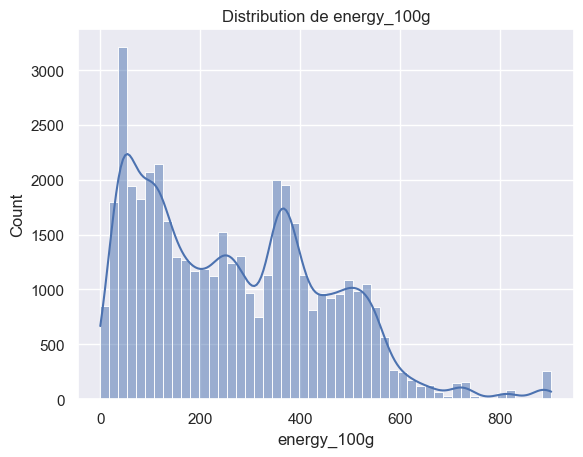

In [159]:
sns.histplot(data_fr_knn_completed['energy_100g'], bins=50, kde=True)
plt.title("Distribution de energy_100g")
plt.show()

#### Nous nous sommes pas echape du comportement initial

In [153]:
nan_values = data_fr_knn_completed.isnull().mean() * 100

# Trier les colonnes par pourcentage de valeurs manquantes
missing_values_sorted = nan_values.sort_values(ascending=False)

missing_values_sorted

brands                     0.477120
proteins_100g              0.257423
fiber_100g                 0.002219
code                       0.000000
product_name               0.000000
nutrition_grade_fr         0.000000
pnns_groups_1              0.000000
energy_100g                0.000000
fat_100g                   0.000000
saturated_fat_100g         0.000000
carbohydrates_100g         0.000000
sugars_100g                0.000000
nutrition_score_fr_100g    0.000000
sel_100g                   0.000000
dtype: float64

In [154]:
data_fr_knn_completed

,code,product_name,brands,nutrition_grade_fr,pnns_groups_1,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,nutrition_score_fr_100g,sel_100g
106,0000000036252,Lion Peanut x2,Sunridge,E,a renseigner,450.047801,20.00,12.5,70.00,57.5,2.5,2.50,22.0,0.09652
138,0000000039529,Pack de 2 Twix,"Twix, Lundberg",nan,a renseigner,353.967495,4.17,2.0,77.08,4.0,6.2,6.25,9.0,0.60000
226,0000040608754,"Pepsi, Nouveau goût !",Pepsi,E,boissons,42.304015,0.00,0.0,10.40,10.4,0.0,0.00,13.0,0.02540
240,0000087177756,7Up,"7Up,Pepsico",E,boissons,42.304015,0.00,0.0,10.40,10.4,0.0,0.00,13.0,0.10000
242,000010,Madeleines nature,Bijou,D,collation sucree,454.110899,23.00,2.5,55.00,26.0,1.5,6.00,12.0,0.66000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320652,9556587103869,Mini Paratha,Kawan,C,cereales et pommes de terre,312.858509,15.00,9.0,41.40,5.1,6.5,6.00,10.0,0.90000
320656,9557129019006,Healtier palm oil (L'huile de palme),Carotino,D,matieres grasses et les sauces,812.619503,92.00,39.0,0.00,0.0,0.0,0.00,16.0,0.00000
320668,9577283844672,100% Pur Jus 4 agrumes,Cora,C,boissons,45.889101,0.50,0.0,10.20,9.2,0.6,0.60,4.0,0.03000
320670,9588400178181,Cacao,Banania,C,a renseigner,374.760994,2.10,1.2,79.00,68.0,6.4,5.70,10.0,0.06000


## L'imputation par KNN c'est bien deroulee

In [156]:
data_fr_knn_completed_shape = data_fr_knn_completed.shape
print(f"Le jeu de donnee contient {data_fr_knn_completed_shape[0]} lignes et {data_fr_knn_completed_shape[1]} colonnes.")

Le jeu de donnee contient 45062 lignes et 14 colonnes.


-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


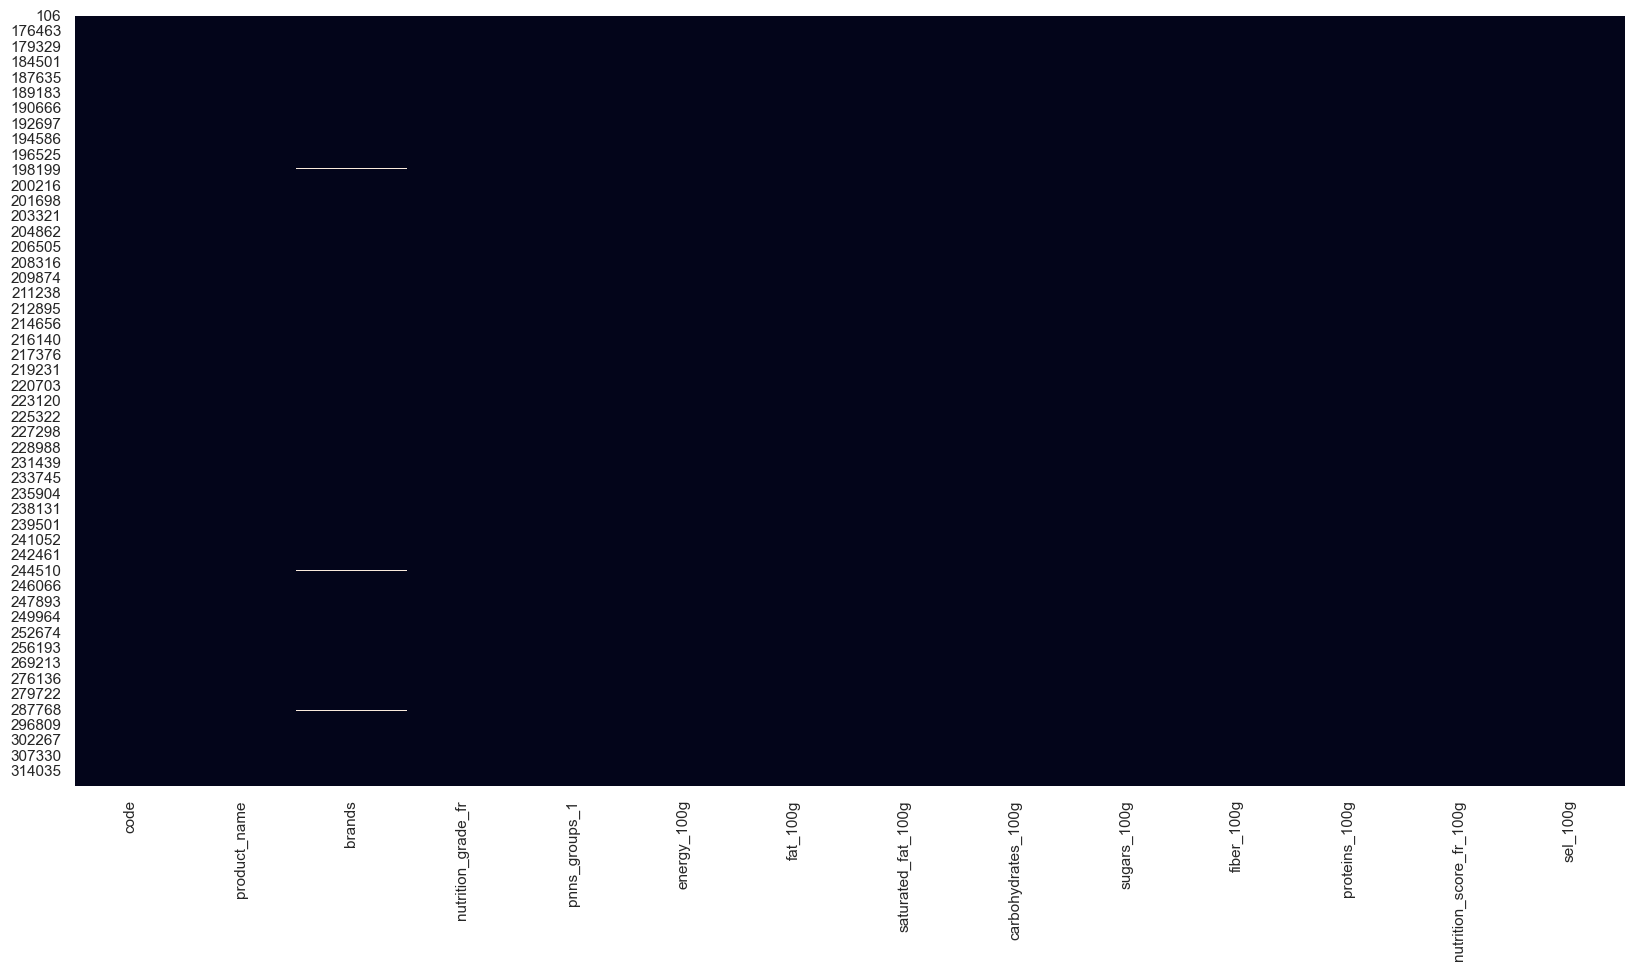

In [157]:
print("-------------------------------------------------------------")
print("Heatmap de visualisation des valeurs manquantes")
plt.figure(figsize=(20, 10))
sns.heatmap(data_fr_knn_completed.isna(), cbar=False)
plt.show()

## Sauvegarde du jeu de donnees

In [158]:
data_fr_knn_completed.to_csv('../Source/openfoodfacts_clean.csv', sep='\t', encoding='utf_8', index=False)

# Respect des normes RGPD pendant l'operation de nettoyage : 
##### 1 - Ne collectez que les données vraiment nécessaires pour atteindre votre objectif : Sur 162 variables, 14 ont ete conservees uniquement. 3 categorielles et 11 numeriques.
##### 2 - Soyez transparent : Sagissant d'une base de donnee open source concernant des informations alimentaire, l'ensemble des donnees est disponible pour tous.
##### 3 - Organisez et facilitez l'exercice des droits des personnes : Sagissant d'une base de donnees open source concernant des informations alimentaire remplis par les utilisateurs le droit de chacun est respecte.
##### 4 - Fixez des durées de conservation : Ces donnees sont utilisees uniquement lors de l'etude dutant le nettoyage et l'analyse. Elles ne seront pas conservees par la suite personnellement.
##### 5 - Sécurisez les données et identifiez les risques : L'ensemble des donnees sont protegees par des securites informatique propre a mon installation. 
##### 6 - Inscrivez la mise en conformité dans une démarche continue : Controle regulier des demarches RGPD.